# TO BE DELETED
## Overview
- [DONE] Follow the universal workflow of DLWP 4.5 (1st edition) for a dataset of your choice.
- [DONE] You can use the tensorflow datasets, MNIST, Reuters, IMDB and Boston Housing Price, or an external dataset. Work exclusively in a Jupyter notebook.
- [DONE] You can only use DLWP Part 1 layers (Chapters 1 - 4) i.e. restrict your models to tensorflow sequential Dense and Dropout layers.
- Your Jupyter notebook should read as a report, not just a sequence of code cells. Structure your report with markdown headings, subheadings, tables etc.
- You can use as much DLWP code and code from the video notebooks as you wish but you must reference all code that is not original: credit will be given for model assembly using third-party code, and extra credit may be awarded for original code.
- Export your Jupyter notebook to html and submit. Do not submit your notebook or any data files. Submit only the html export of your notebook.

### NOT FOR ME
(For Colab users: Colab does not have an html facility. Either:
- Download the colab notebook and load into Jupyter; you will then be able to export as html OR follow the instructions in this blog i.e. download from colab and then reload into colab's session storage.
- Then run the script: %%shelljupyter nbconvert --to html /Your notebook path/file.ipynb and download the html version)

## REVIEW CRITERIA
Credit will be awarded for:
- report structure and quality as a document
- adherence to the deep learning workflow
- a systematic investigation
- interpretation of results

Additional credit may be awarded for:
- modular programming
- external dataset (but not an online tutorial dataset)
- extensive experimentation
- understanding and technique that exceeds the module syllabus

## DLWP 4.5 CHAPTER SUMMARY
- Define the problem at hand and the data on which you’ll train. Collect this data, or annotate it with labels if need be
- Choose how you’ll measure success on your problem. Which metrics will you monitor on your validation data?
- Determine your evaluation protocol: hold-out validation? K-fold validation? Which portion of the data should you use for validation?
- Develop a first model that does better than a basic baseline: a model with statistical power
- Develop a model that overfits
- Regularize your model and tune its hyperparameters, based on performance on the validation data. A lot of machine-learning research tends to focus only on this step—but keep the big picture in mind

---

# The Universal Workflow of Machine Learning
This project centers around the universal workflow of **DLWP 4.5** on the **CIFAR-10** small images classification datatset in Keras. The aim for this project is to produce a model that produces the best results through learning features through Tensorflow's sequential ```Dense``` and ```Dropout``` layers.

## 1 Defining the problem
### 1.1 Datatype
**Input Data:**
- 60,000 colour images of shape (32, 32, 3)
- Each colour images represents a different object class (vehicles and animals)
- There are 50,000 training images, and 10,000 test images

<br>**Output Data:** A classification label (0-9), representing 10 different categories

<center><img src="images/CIFAR10_dataset_categories.jpg" style="width: 50%" alt="CIFAR10 Dataset Categories"></img>
<br><b><a href="https://keras.io/api/datasets/cifar10/">1 The CIFAR-10 Dataset Categories</a><b></center>

### 1.2 Problem Type and Goals
Classification of raw images into categories is valuable across industries. By training a model that could accurately classify images based on features and labels, Machine Learning can be implemented to aid in real-world problems like Breast Cancer Detection. ( **<a href="https://www.nejm.org/doi/full/10.1056/nejmoa1206809">2 Bleyer and Welch, 2012</a>** )

- **Problem Type:** Multiclass classification - one of 10 possible classes must be assigned to each one of the 10,000 test images.
- **Hypothesis:** The CIFAR-10 dataset is large enough and contains enough visual information for the model to learn generalised relationships between inputs and outputs such that it is able to accurately classify unseen.

#### TO BE DELETED
```Multiclass classification? Scalar regression? Vector regression? Multiclass, multilabel classification? Something else, like clustering, generation, or reinforcement learning? Identifying the problem type will guide your choice of model architecture, loss function, and so on.```


In [20]:
# PREPARATION FOR CODE
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

## 2 Assembling the dataset
To begin, the CIFAR-10 dataset is loaded and split into its relevant ```train_images```, ```train_labels```, ```test_images```, and ```test_labels```. To understand the data better, the shape of the training and test sets are displayed. To view the different classes in the data, 10 images of each class is displayed.

Train Images: (50000, 32, 32, 3) Train Labels: (50000, 1)
Test Images: (10000, 32, 32, 3) Test Labels: (10000, 1)


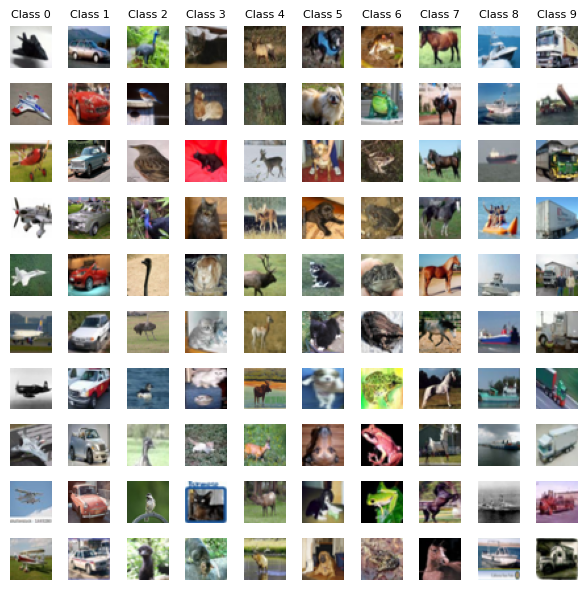

In [2]:
# LOADING CIFAR-10 DATASET
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

# EXPLORING DATASET SHAPE
print("Train Images:", train_images.shape, "Train Labels:", train_labels.shape)
print("Test Images:", test_images.shape, "Test Labels:", test_labels.shape)

# VISUALISING SAMPLES
# flattening train_labels to a 1D array
train_labels = train_labels.flatten()
# getting first 10 class IDs in order (0-9)
classes = sorted(set(train_labels))[:10]

# creating a 10 x 10 figure
fig, axes = plt.subplots(10, 10, figsize = (6, 6))

# plotting first 10 images of each class
for i, class_id in enumerate(classes):
    # find idxs of images belonging to the current class
    class_idxs = np.where(train_labels == class_id)[0]
    # select first 10 images from each class
    selected_idxs = class_idxs[:10]
    # display class label at top of column
    axes[0, i].set_title(f"Class {class_id}", fontsize = 8)
    
    # iterating over selected images
    for j, img_idx in enumerate(selected_idxs):
        # getting the image
        img = train_images[img_idx]
        # displaying image
        axes[j, i].imshow(img)
        axes[j, i].axis("off")
        
# adjusting layout
plt.tight_layout(rect = [0, 0, 1, 1])
plt.show()

## 3 Choosing a measure of success
Given the description provided on CIFAR-10 ( <b><a href="https://www.cs.toronto.edu/~kriz/cifar.html">3 Krizhevsky, 2009</a><b> ):
> "The test batch contains exactly 1000 randomly-selected images from each class."

<br>The dataset is balanced, making ```accuracy``` a suitable metric. <br>The accuracy score is calculated as follows:

$$
Accuracy = \frac{TP + TN}{TP + FP + TN + FN}
$$

<br>To analyse the class-specific misclassification trends, ```confusion matrix``` will also be implemented.

#### TO BE DELETED
```To control something, you need to be able to observe it. To achieve success, you must define what you mean by success—accuracy? Precision and recall? Customer-retention rate? Your metric for success will guide the choice of a loss function: what your model will optimize. It should directly align with your higher-level goals, such as the success of your business. For balanced-classification problems, where every class is equally likely, accuracy and area under the receiver operating characteristic curve (ROC AUC) are common metrics. For class-imbalanced problems, you can use precision and recall. For ranking problems or multilabel classification, you can use mean average precision. And it isn’t uncommon to have to define your own custom metric by which to measure success. To get a sense of the diversity of machine-learning success metrics and how they relate to different problem domains, it’s helpful to browse the data science competitions on Kaggle (https://kaggle.com); they showcase a wide range of problems and evaluation metrics.```

## 4 Deciding on an evaluation protocol
To measure the current progress, the evaluation protocol chosen would be **a hold-out validation set**. Since the CIFAR-10 dataset contains **50,000 training images**, the dataset can be split into **80% training and 20% validation**. This ensures that the model learns from 40,000 training images, and 10,000 validation images are available for **unbiased evaluation** before testing it on unseen data.

## 5 Preparation and baseline
### 5.1 Preparing your data
To ensure that the data can be fed into the network, the data needs to be formatted as tensors. For this case, the CIFAR-10 dataset consists of images with a shape of **(32, 32, 3)**, representing **32x32 pixel RGB images**. Since the model is fully connected with Dense layers, the images need to be reshaped into 1D vectors of size **32 x 32 x 3 = 3027**. This transformation will ensure that each image is represented as a single tensor of shape **(3027, )**.

Next, the pixel values are normalised by dividing the reshaped values by **255.0**, scaling them to the **[0, 1] range**. This normalisation will help to improve numerical stability which accelerates training by keeping all input values within a small, consistent range.

#### TO BE DELETED
```Once you know what you’re training on, what you’re optimizing for, and how to evaluate your approach, you’re almost ready to begin training models. But first, you should format your data in a way that can be fed into a machine-learning model — here, we’ll assume a deep neural network:```

- As you saw previously, your data should be formatted as tensors
- The values taken by these tensors should usually be scaled to small values: for example, in the [-1, 1] range or [0, 1] range
- If different features take values in different ranges (heterogeneous data), then the data should be normalized
- You may want to do some feature engineering, especially for small-data problems

```Once your tensors of input data and target data are ready, you can begin to train models```

In [3]:
# flattening images and normalising data
x_train = train_images.reshape((50000, 32*32*3)).astype("float32") / 255.0
x_test = test_images.reshape((10000, 32*32*3)).astype("float32") / 255.0
print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)

# preparing the labels
y_train = to_categorical(train_labels, num_classes = 10).astype("float")
y_test = to_categorical(test_labels, num_classes = 10).astype("float")
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

x_train shape: (50000, 3072)
x_test shape: (10000, 3072)
y_train shape: (50000, 10)
y_test shape: (10000, 10)


### 5.2 Establishing baseline model
Based on **DLWP Chapter 2**, the base model shown was replicated, and the input shape was modified to fit the 32x32 pixel RGB images. The model was then trained on training set with a batch size of 128 for 5 epochs, as shown in the reference.

Compilation was done following the reference, but further developments will consider finding the best combination for the loss function and optimizer used. The following rephrased quote describes what the loss function and optimizer does:
> The loss function determines how the network will be able to measure its performance on the training data, and thus how it will be able to steer itself in the right direction. An optimizer is the mechanism through which the network will update itself based on the data it sees and its loss function.

In [4]:
model = models.Sequential([
    layers.Dense(512, activation = "relu", input_shape = (32*32*3,)),
    layers.Dense(10, activation = "softmax") # 10 classes
])

model.compile( optimizer = "rmsprop", loss = "categorical_crossentropy", metrics = ["accuracy"] )
history_a = model.fit(x_train, y_train, epochs = 5, batch_size = 128)

C:\Users\sbgka\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.2108 - loss: 3.1098
Epoch 2/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3409 - loss: 1.8380
Epoch 3/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3847 - loss: 1.7311
Epoch 4/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4103 - loss: 1.6699
Epoch 5/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4209 - loss: 1.6374


The same training was also done with the evaluation protocol of a hold-out validation set. It is noted that even with the implementation of a validation split, there was no significant improvement to the loss and accuracy, suggesting the inconclusivity of the importance of the evaluation protocol with a small number of epochs.

In [5]:
model = models.Sequential([
    layers.Dense(512, activation = "relu", input_shape = (32*32*3,)),
    layers.Dense(10, activation = "softmax") # 10 classes
])

model.compile( optimizer = "rmsprop", loss = "categorical_crossentropy", metrics = ["accuracy"] )
history_b = model.fit(x_train, y_train, epochs = 5, batch_size = 128, validation_split = 0.2)

Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2062 - loss: 3.0953 - val_accuracy: 0.2749 - val_loss: 1.9923
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3298 - loss: 1.8679 - val_accuracy: 0.3605 - val_loss: 1.7850
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3748 - loss: 1.7495 - val_accuracy: 0.3591 - val_loss: 1.7629
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3995 - loss: 1.6886 - val_accuracy: 0.3390 - val_loss: 1.8815
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4158 - loss: 1.6518 - val_accuracy: 0.3635 - val_loss: 1.7985


To evaluate the model's actual performance, the models will be modified to include a ```Dropout``` rate to prevent overfitting, and trained with a larger number of epochs. These new models will then be evaluated on the test set. To confirm that the evaluation protocol was successful, the training accuracy and loss will be plotted.

Based on the output, it is proven that after adding a ```Dropout``` to the model, including a validation split has significantly improved the test accuracy whilst decreasing the model's loss. It is also noted that the ```val_accuracy``` has an **overall decreasing trend**, whilst the ```val_loss``` has an **overall increasing trend**.

In [6]:
def build_model():
    model = models.Sequential([
        layers.Dense(512, activation = "relu", input_shape = (32*32*3,)),
        layers.Dropout(0.3),
        layers.Dense(10, activation = "softmax") # 10 classes
    ])

    model.compile(
        optimizer = "rmsprop",
        loss = "categorical_crossentropy",
        metrics = ["accuracy"]
    )
    
    return model

model_wo_val = build_model()
history_a = model.fit(x_train, y_train, epochs = 100, batch_size = 128)
model_w_val = build_model()
history_b = model.fit(x_train, y_train, epochs = 100, batch_size = 128, validation_split = 0.2)

Epoch 1/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4244 - loss: 1.6209
Epoch 2/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4385 - loss: 1.5857
Epoch 3/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4499 - loss: 1.5509
Epoch 4/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4565 - loss: 1.5273
Epoch 5/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4667 - loss: 1.5141
Epoch 6/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4718 - loss: 1.4979
Epoch 7/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4711 - loss: 1.4863
Epoch 8/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4821 - loss: 1.4563
Epoch 9/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4892 - loss: 1.4386
Epoch 10/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4968 - loss: 1.4344
Epoch 11/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5003 - loss: 1.4114
Epoch 12/100
391/391 ━━━━━━━━━━━━━━━━━━━━

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step - accuracy: 0.1036 - loss: 2.5552
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step - accuracy: 0.0992 - loss: 2.6421
Test Accuracy WITHOUT Validation Split: 0.10289999842643738
Test Accuracy WITH Validation Split: 0.10010000318288803


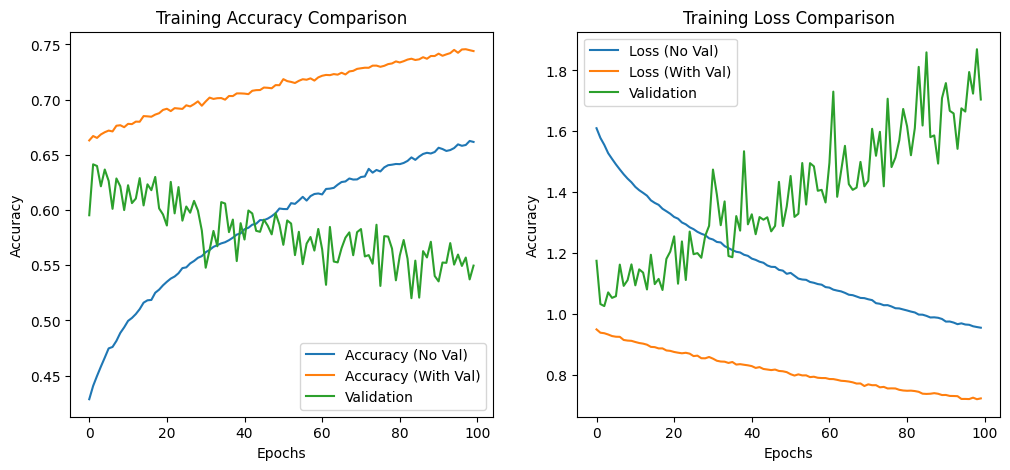

In [7]:
# evaluating model on test set
test_loss, test_acc = model_wo_val.evaluate(x_test, y_test)
test_loss_val, test_acc_val = model_w_val.evaluate(x_test, y_test)

# DISPLAYING TEST ACCURACY
print(f"Test Accuracy WITHOUT Validation Split: {test_acc}")
print(f"Test Accuracy WITH Validation Split: {test_acc_val}")

# PLOTTING LEARNING CURVE
fig, axes = plt.subplots(1, 2, figsize = (12, 5))
# plotting accuracy
axes[0].plot(history_a.history["accuracy"], label = "Accuracy (No Val)")
axes[0].plot(history_b.history["accuracy"], label = "Accuracy (With Val)")
axes[0].plot(history_b.history["val_accuracy"], label = "Validation")
axes[0].set_title("Training Accuracy Comparison")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Accuracy")
axes[0].legend()
# plotting loss
axes[1].plot(history_a.history["loss"], label = "Loss (No Val)")
axes[1].plot(history_b.history["loss"], label = "Loss (With Val)")
axes[1].plot(history_b.history["val_loss"], label = "Validation")
axes[1].set_title("Training Loss Comparison")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Accuracy")
axes[1].legend()
# plotting graph
plt.show()

Note that the confusion matrix does not seem to be working well for this section.

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step
145/313 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step

C:\Users\sbgka\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sbgka\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sbgka\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step

Classification Report w/o Validation:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1000
           1       0.20      0.01      0.02      1000
           2       0.08      0.25      0.12      1000
           3       0.00      0.00      0.00      1000
           4       0.11      0.74      0.20      1000
           5       0.20      0.00      0.00      1000
           6       0.00      0.00      0.00      1000
           7       0.05      0.02      0.02      1000
           8       0.00      0.00      0.00      1000
           9       0.00      0.00      0.00      1000

    accuracy                           0.10     10000
   macro avg       0.06      0.10      0.04     10000
weighted avg       0.06      0.10      0.04     10000


Classification Report w/ Validation:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1000
           1

C:\Users\sbgka\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sbgka\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sbgka\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

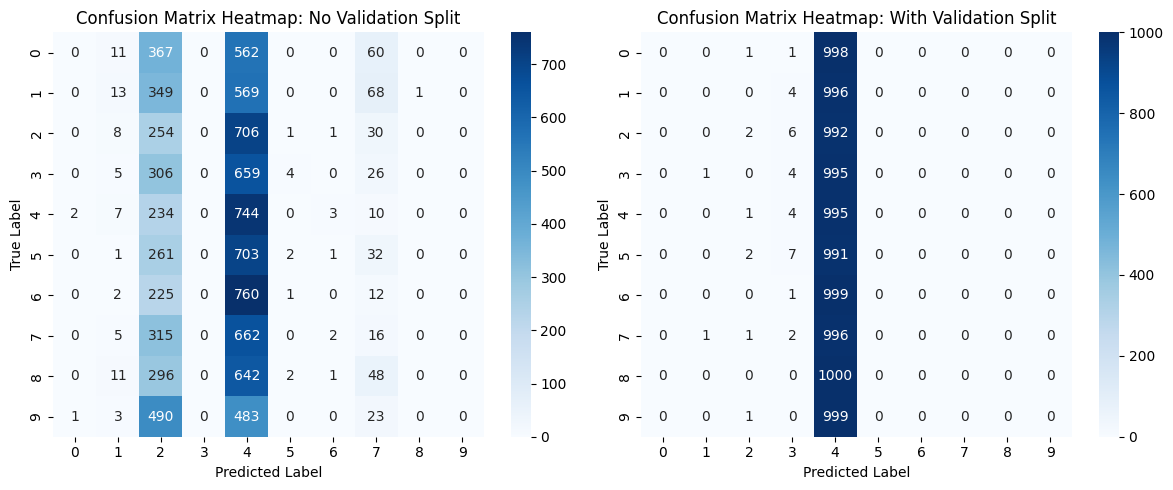

In [8]:
# GENERATING CONFUSION MATRIX
def get_conf_matrix(model):
    # predicting class probability
    y_pred = model.predict(x_test)
    # converting to one-hot to class indices
    y_pred_classes = np.argmax(y_pred, axis = 1)
    y_true_classes = np.argmax(y_test, axis = 1)
    # generating confusion matrix
    return confusion_matrix(y_true_classes, y_pred_classes), classification_report(y_true_classes, y_pred_classes)

cm_a, cr_a = get_conf_matrix(model_wo_val)
cm_b, cr_b = get_conf_matrix(model_w_val)

# DISPLAYING CLASSIFICATION REPORT
print("\nClassification Report w/o Validation:")
print(cr_a)
print("\nClassification Report w/ Validation:")
print(cr_b)

# PLOTTING SIDE-BY-SIDE HEATMAPS
fig, axes = plt.subplots(1, 2, figsize = (12, 5))
# getting heatmap for model without validation
sns.heatmap(cm_a, annot = True,
            fmt = "d", cmap = "Blues",
            xticklabels = range(10), yticklabels = range(10), ax = axes[0])
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")
axes[0].set_title("Confusion Matrix Heatmap: No Validation Split")
# getting heatmap for model with validation
sns.heatmap(cm_b, annot = True,
            fmt = "d", cmap = "Blues",
            xticklabels = range(10), yticklabels = range(10), ax = axes[1])
axes[1].set_xlabel("Predicted Label")
axes[1].set_ylabel("True Label")
axes[1].set_title("Confusion Matrix Heatmap: With Validation Split")

plt.tight_layout()
plt.show()

## 5 Developing a model that does better than a baseline
In this stage, the goal is to achieve statistical power, a model is to be developed capable of beating the current baseline model that has an accuracy of 0.10 after implementing a validation split. To view the performance, a function ```disp_performance()``` is created to display the ```accuracy```, ```val_accuracy```, ```loss``` and ```val_loss```, together with the confusion matrix.

#### TO BE DELETED
```Your goal at this stage is to achieve statistical power: that is, to develop a small model that is capable of beating a dumb baseline. In the MNIST digit-classification example, anything that achieves an accuracy greater than 0.1 can be said to have statistical power; in the IMDB example, it’s anything with an accuracy greater than 0.5.```

```Note that it’s not always possible to achieve statistical power. If you can’t beat a random baseline after trying multiple reasonable architectures, it may be that the answer to the question you’re asking isn’t present in the input data. Remember that you make two hypotheses:```

- You hypothesize that your outputs can be predicted given your inputs
- You hypothesize that the available data is sufficiently informative to learn the relationship between inputs and outputs

```It may well be that these hypotheses are false, in which case you must go back to the drawing board.```
```Assuming that things go well, you need to make three key choices to build your first working model:```

- Last-layer activation: This establishes useful constraints on the network’s output. For instance, the IMDB classification example used sigmoid in the last layer; the regression example didn’t use any last-layer activation; and so on
- Loss function: This should match the type of problem you’re trying to solve. For instance, the IMDB example used binary_crossentropy, the regression example used mse, and so on
- Optimization configuration: What optimizer will you use? What will its learning rate be? In most cases, it’s safe to go with rmsprop and its default learning rate

```Regarding the choice of a loss function, note that it isn’t always possible to directly optimize for the metric that measures success on a problem. Sometimes there is no easy way to turn a metric into a loss function; loss functions, after all, need to be computable given only a mini-batch of data (ideally, a loss function should be computable for as little as a single data point) and must be differentiable (otherwise, you can’t use backpropagation to train your network). For instance, the widely used classification metric ROC AUC can’t be directly optimized. Hence, in classification tasks, it’s common to optimize for a proxy metric of ROC AUC, such as crossentropy. In general, you can hope that the lower the crossentropy gets, the higher the ROC AUC will be. Table 4.1 can help you choose a last-layer activation and a loss function for a few common problem types.```

In [4]:
# FUNCTION TO DISPLAY RESULTS
def disp_performance(model, history):
    # evaluating model on test set
    test_loss, test_acc = model.evaluate(x_test, y_test)
    # DISPLAYING TEST ACCURACY
    print(f"Test Accuracy: {test_acc}")
    
    # PLOTTING LEARNING CURVE
    fig, axes = plt.subplots(1, 3, figsize = (16, 5))
    # plotting accuracy
    axes[0].plot(history.history["accuracy"], label = "Accuracy")
    axes[0].plot(history.history["val_accuracy"], label = "Validation")
    axes[0].set_title("Training Accuracy")
    axes[0].set_xlabel("Epochs")
    axes[0].set_ylabel("Accuracy")
    axes[0].legend()
    # plotting loss
    axes[1].plot(history.history["loss"], label = "Loss")
    axes[1].plot(history.history["val_loss"], label = "Validation")
    axes[1].set_title("Training Loss")
    axes[1].set_xlabel("Epochs")
    axes[1].set_ylabel("Accuracy")
    axes[1].legend()

    # GENERATING CONFUSION MATRIX
    # predicting class probability
    y_pred = model.predict(x_test)
    # converting to one-hot to class indices
    y_pred_classes = np.argmax(y_pred, axis = 1)
    y_true_classes = np.argmax(y_test, axis = 1)
    # generating confusion matrix
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    cr = classification_report(y_true_classes, y_pred_classes)

    # DISPLAYING CLASSIFICATION REPORT
    print("\nClassification Report:")
    print(cr)

    # PLOTTING HEATMAPS
    # getting heatmap for model without validation
    sns.heatmap(cm, annot = True,
                fmt = "d", cmap = "Blues",
                xticklabels = range(10), yticklabels = range(10), ax = axes[2])
    axes[2].set_xlabel("Predicted Label")
    axes[2].set_ylabel("True Label")
    axes[2].set_title("Confusion Matrix Heatmap")
    
    plt.tight_layout()
    plt.show()

# # TESTING FUNCTION WORKS
# model = models.Sequential([
#     layers.Dense(512, activation = "relu", input_shape = (32*32*3,)),
#     layers.Dense(10, activation = "softmax") # 10 classes
# ])

# model.compile( optimizer = "rmsprop", loss = "categorical_crossentropy", metrics = ["accuracy"] )
# history = model.fit(x_train, y_train, epochs = 5, batch_size = 128, validation_split = 0.2)
# disp_performance(model, history)

### 5.1 Determining compilation combination
To ensure that the model is compiled with the best combination of loss function and optimizer, this step will focus on finding the right loss function and optimizer for the CIFAR-10 dataset. To build the models with a base template, a function ```build_model2()``` takes in combinations of loss functions and optimizers and builds the models.

In [10]:
def build_model2(model_opt, model_loss):
    model = models.Sequential([
        layers.Dense(512, activation = "relu", input_shape = (32*32*3,)),
        layers.Dropout(0.3),
        layers.Dense(10, activation = "softmax") # 10 classes
    ])

    model.compile(
        optimizer = model_opt,
        loss = model_loss,
        metrics = ["accuracy"]
    )
    
    return model

#### 5.1.1 Determining optimizer
For this project, the optimizers compared are ```RMSprop``` and ```Adam```.

- ```RMSprop``` was chosen because it was used in the DLWP Book, ```RMSprop``` maintains a moving (discounted) average of squared gradients, then divides the gradients by the root of this average.
- ```Adam``` was chosen because it is a **stochastic gradient descent (SGD)** method adapting both first-order and second-order moments. The method is "computationally efficient, has little memory requirement, invariant to diagonal rescaling of gradients, and is well suited for problems that are large in terms of data/parameters" ( <b><a href="https://arxiv.org/abs/1412.6980">4 Kingma and Ba, 2014</a><b> ).

It was noted from the results that with either loss functions, the ```Adam``` optimizer performs better than the ```RMSprop``` optimizer. As such, it will be chosen for compilation.

#### 5.1.2 Determining loss function
For this project, the loss functions compared are ```CategoricalCrossentropy``` and ```CategoricalFocalCrossentropy```.

- ```CategoricalCrossentropy``` was chosen as it is the standard loss function chosen for **multi-class classification problems**, similar to this project. It was also used in the DLWP Book. ```CategoricalCrossentropy``` is generally used when there are 2 or more label classes. It assumes that there are **balanced class distributions**.
- ```CategoricalFocalCrossentropy``` was chosen as it focuses on **harder-to-classify examples**. This is generally used for imbalanced datasets, where some classes have significantly fewer samples than others.

It was noted from the results that whilst the model performance in accuracy was similar when comparing ```CategoricalCrossentropy``` to ```CategoricalFocalCrossentropy```, ```CategoricalFocalCrossentropy``` was significantly better in lowering loss. This is due to the fact that focal loss reduces the impact of easy-to-classify samples, making the model more optimised for harder cases.

However, since the dataset is balanced, a lower loss value does not suggest a better accuracy, as such, ```CategoricalCrossentropy``` will be chosen as attempting to focus on harder-to-classify samples when the data has already been defined to be balanced may not be beneficial in the long-run.

In [11]:
mRMS_cat = build_model2("RMSprop", "categorical_crossentropy")
history1 = mRMS_cat.fit(x_train, y_train, epochs = 100, batch_size = 128, validation_split = 0.2)
mAdam_cat = build_model2("Adam", "categorical_crossentropy")
history2 = mAdam_cat.fit(x_train, y_train, epochs = 100, batch_size = 128, validation_split = 0.2)
mRMS_focal = build_model2("RMSprop", "categorical_focal_crossentropy")
history3 = mRMS_focal.fit(x_train, y_train, epochs = 100, batch_size = 128, validation_split = 0.2)
mAdam_focal = build_model2("Adam", "categorical_focal_crossentropy")
history4 = mAdam_focal.fit(x_train, y_train, epochs = 100, batch_size = 128, validation_split = 0.2)

Epoch 1/100


C:\Users\sbgka\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.1944 - loss: 2.9712 - val_accuracy: 0.3051 - val_loss: 1.9056
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3051 - loss: 1.9203 - val_accuracy: 0.3342 - val_loss: 1.8702
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3389 - loss: 1.8442 - val_accuracy: 0.3541 - val_loss: 1.7822
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3574 - loss: 1.7992 - val_accuracy: 0.3675 - val_loss: 1.7906
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3650 - loss: 1.7700 - val_accuracy: 0.3665 - val_loss: 1.8156
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3779 - loss: 1.7437 - val_accuracy: 0.3969 - val_loss: 1.6992
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3884 - loss: 1.7221 - val_accuracy: 0.3901 - val_loss: 1.7079
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3941 - loss: 1.6955 - val_accuracy: 0.3933

RMSprop, categorical_crossentropy
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4642 - loss: 1.6017  
Test Accuracy: 0.4629000127315521
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step

Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.64      0.50      1000
           1       0.61      0.55      0.58      1000
           2       0.28      0.26      0.27      1000
           3       0.42      0.15      0.22      1000
           4       0.34      0.54      0.42      1000
           5       0.41      0.38      0.39      1000
           6       0.59      0.45      0.51      1000
           7       0.56      0.50      0.53      1000
           8       0.55      0.62      0.59      1000
           9       0.54      0.53      0.53      1000

    accuracy                           0.46     10000
   macro avg       0.47      0.46      0.46     10000
weighted avg       0.47      0.46      0.46     10000



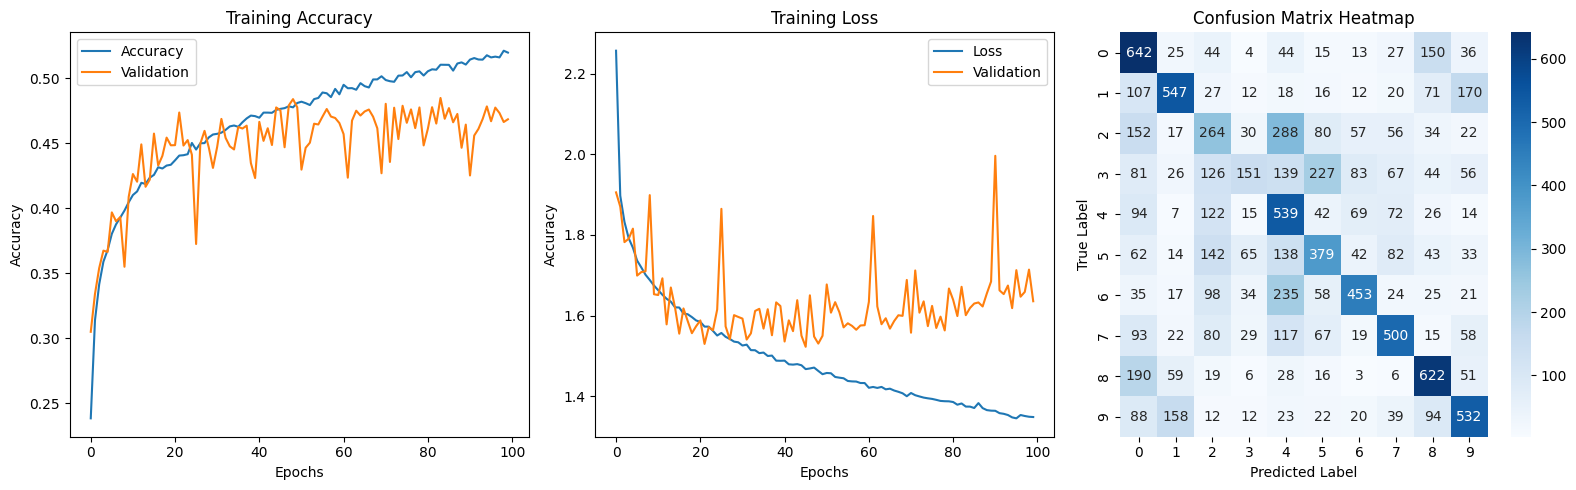

Adam, categorical_crossentropy
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4595 - loss: 1.5166
Test Accuracy: 0.4560999870300293
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step

Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.57      0.52      1000
           1       0.60      0.56      0.58      1000
           2       0.37      0.18      0.24      1000
           3       0.28      0.36      0.32      1000
           4       0.40      0.39      0.40      1000
           5       0.41      0.31      0.35      1000
           6       0.42      0.61      0.50      1000
           7       0.51      0.54      0.52      1000
           8       0.58      0.56      0.57      1000
           9       0.56      0.48      0.52      1000

    accuracy                           0.46     10000
   macro avg       0.46      0.46      0.45     10000
weighted avg       0.46      0.46      0.45     10000



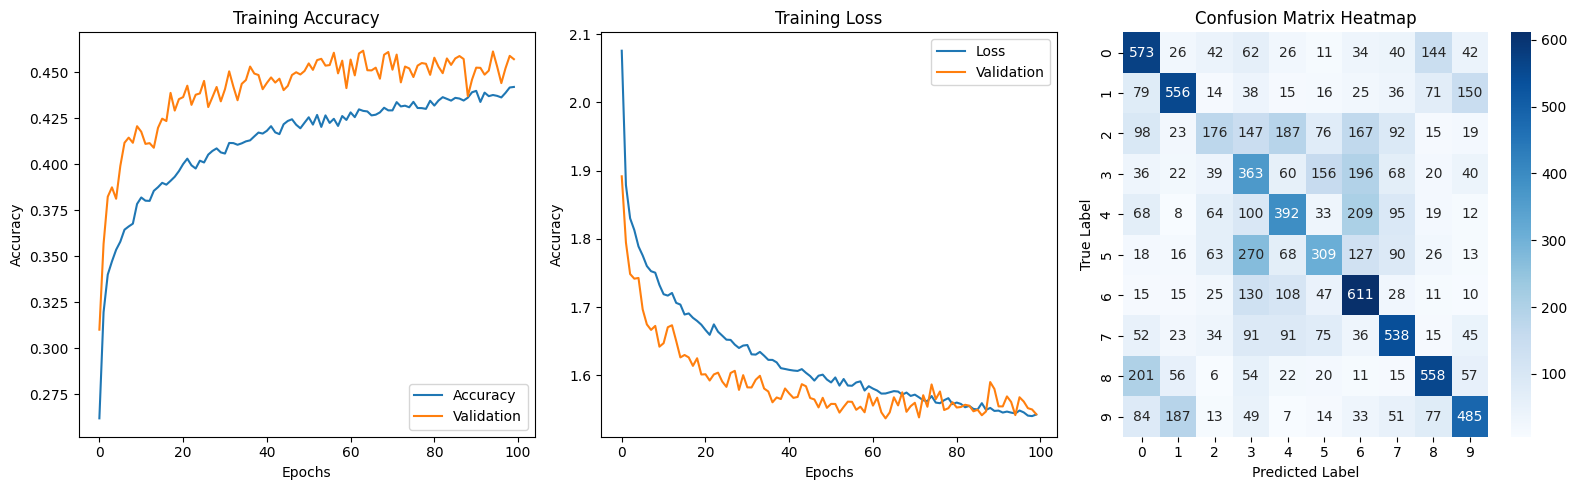

RMSprop, categorical_focal_crossentropy
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4567 - loss: 0.2826
Test Accuracy: 0.4595000147819519
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step

Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.43      0.50      1000
           1       0.63      0.53      0.57      1000
           2       0.33      0.23      0.28      1000
           3       0.35      0.17      0.23      1000
           4       0.31      0.62      0.41      1000
           5       0.42      0.38      0.40      1000
           6       0.45      0.57      0.51      1000
           7       0.54      0.49      0.51      1000
           8       0.53      0.66      0.59      1000
           9       0.55      0.52      0.53      1000

    accuracy                           0.46     10000
   macro avg       0.47      0.46      0.45     10000
weighted avg       0.47      0.46      0.45     10000



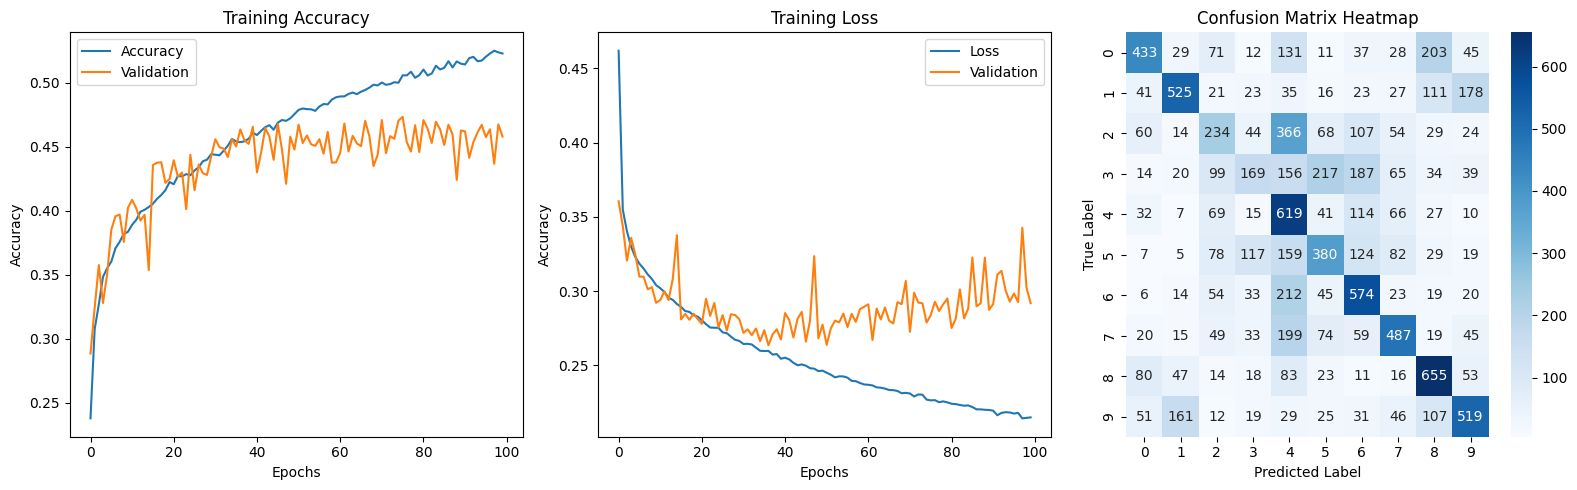

Adam, categorical_focal_crossentropy
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4590 - loss: 0.2589  
Test Accuracy: 0.45579999685287476
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step

Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.59      0.52      1000
           1       0.55      0.55      0.55      1000
           2       0.33      0.26      0.29      1000
           3       0.36      0.22      0.27      1000
           4       0.41      0.39      0.40      1000
           5       0.38      0.40      0.39      1000
           6       0.48      0.56      0.52      1000
           7       0.55      0.50      0.52      1000
           8       0.50      0.57      0.53      1000
           9       0.48      0.52      0.50      1000

    accuracy                           0.46     10000
   macro avg       0.45      0.46      0.45     10000
weighted avg       0.45      0.46      0.45     10000



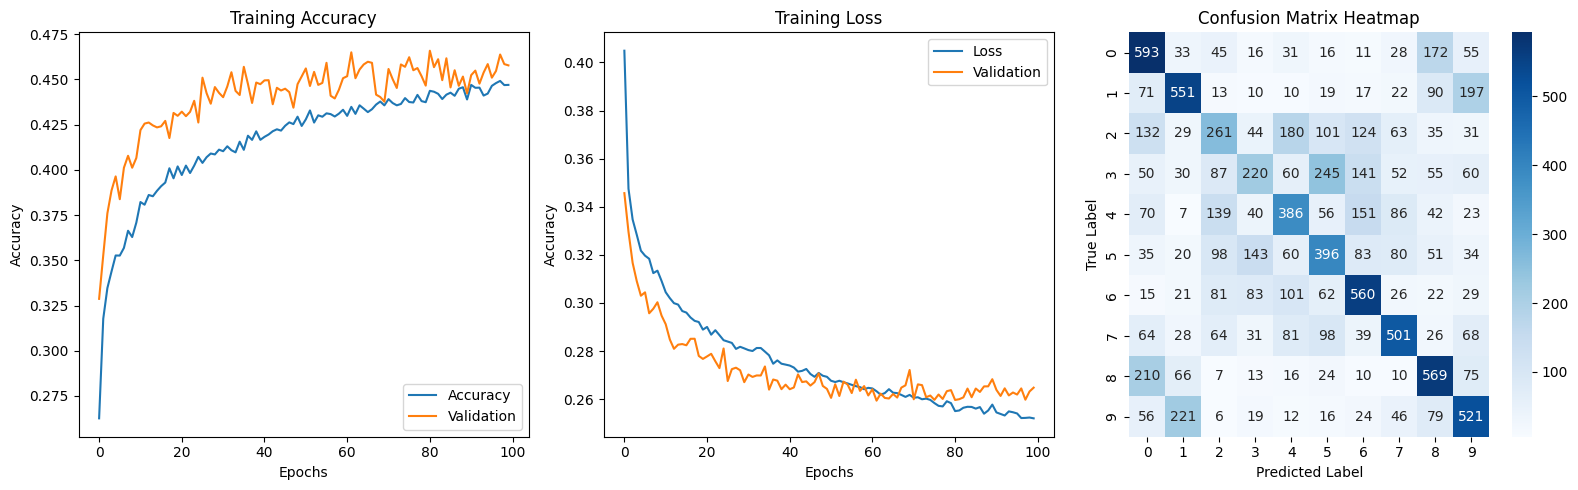

In [12]:
print("RMSprop, categorical_crossentropy")
disp_performance(mRMS_cat, history1)
print("Adam, categorical_crossentropy")
disp_performance(mAdam_cat, history2)
print("RMSprop, categorical_focal_crossentropy")
disp_performance(mRMS_focal, history3)
print("Adam, categorical_focal_crossentropy")
disp_performance(mAdam_focal, history4)

### 5.2 Improving the model
#### 5.2.1 Adding more ```Dense``` layers
With the selected compiler combination, an enhanced model will be created with more layers for better feature extraction. By adding more ```Dense``` layers, the model will have more depth to learn progressively and learn more abstract representations as compared to extracting features with a singular layer.

With this, the model has reached an accuracy of 0.50, suggesting this model has achieved statistical power. However, due to the loss being large, further experiments will be done until the loss is reduced and the accuracy returns to 0.50.

In [13]:
model_dense = models.Sequential([
    layers.Dense(1024, activation = "relu", input_shape = (32*32*3,)),
    layers.Dense(512, activation = "relu"),
    layers.Dense(256, activation = "relu"),
    layers.Dropout(0.3),
    layers.Dense(10, activation = "softmax") # 10 classes
])

model_dense.compile( optimizer = "Adam", loss = "categorical_crossentropy", metrics = ["accuracy"] )
history = model_dense.fit(x_train, y_train, epochs = 100, batch_size = 128, validation_split = 0.2)

Epoch 1/100


C:\Users\sbgka\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.2144 - loss: 2.1861 - val_accuracy: 0.3646 - val_loss: 1.7887
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.3602 - loss: 1.7809 - val_accuracy: 0.3941 - val_loss: 1.6988
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.3989 - loss: 1.6796 - val_accuracy: 0.4150 - val_loss: 1.6578
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.4271 - loss: 1.5958 - val_accuracy: 0.4221 - val_loss: 1.6061
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.4460 - loss: 1.5444 - val_accuracy: 0.4258 - val_loss: 1.6158
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.4576 - loss: 1.5171 - val_accuracy: 0.4484 - val_loss: 1.5498
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.4694 - loss: 1.4743 - val_accuracy: 0.4647 - val_loss: 1.5087
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.4892 - loss: 1.4358 - val_accuracy

3 Dense Layered Model
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5032 - loss: 3.2183
Test Accuracy: 0.5059000253677368
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.61      0.60      1000
           1       0.63      0.57      0.60      1000
           2       0.40      0.37      0.38      1000
           3       0.34      0.38      0.35      1000
           4       0.44      0.42      0.43      1000
           5       0.41      0.39      0.40      1000
           6       0.53      0.57      0.55      1000
           7       0.56      0.55      0.56      1000
           8       0.63      0.64      0.64      1000
           9       0.54      0.56      0.55      1000

    accuracy                           0.51     10000
   macro avg       0.51      0.51      0.51     10000
weighted avg       0.51      0.51      0.51     10000



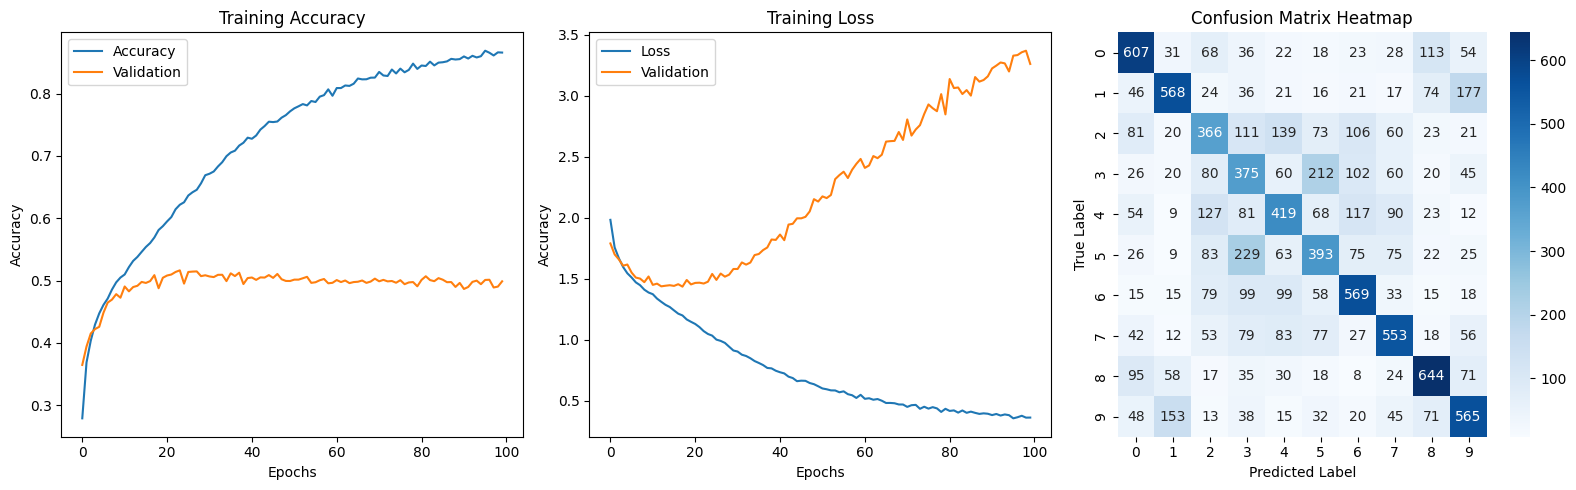

In [14]:
print("3 Dense Layered Model")
disp_performance(model_dense, history)

#### 5.2.2 Adding ```Dropout``` for each ```Dense``` layer
It was noted that whilst the accuracy showed a slight improvement, the loss increased significantly. This is due to the fact that adding additional ```Dense``` layers increases the model's complexity, and the number of trainable parameters. To prevent this, a ```Dropout``` layer will be added between each ```Dense``` layer to improve regularisation and the model's generalisation capabilities.

In [15]:
model_dense_dropout = models.Sequential([
    layers.Dense(1024, activation = "relu", input_shape = (32*32*3,)),
    layers.Dropout(0.3),
    layers.Dense(512, activation = "relu"),
    layers.Dropout(0.3),
    layers.Dense(256, activation = "relu"),
    layers.Dropout(0.3),
    layers.Dense(10, activation = "softmax") # 10 classes
])

model_dense_dropout.compile( optimizer = "Adam", loss = "categorical_crossentropy", metrics = ["accuracy"] )
history = model_dense_dropout.fit(x_train, y_train, epochs = 100, batch_size = 128, validation_split = 0.2)

Epoch 1/100


C:\Users\sbgka\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.1894 - loss: 2.2290 - val_accuracy: 0.3089 - val_loss: 1.9014
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.2931 - loss: 1.9298 - val_accuracy: 0.3317 - val_loss: 1.8503
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.3161 - loss: 1.8680 - val_accuracy: 0.3592 - val_loss: 1.7791
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.3289 - loss: 1.8335 - val_accuracy: 0.3786 - val_loss: 1.7539
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.3476 - loss: 1.8020 - val_accuracy: 0.3704 - val_loss: 1.7503
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.3554 - loss: 1.7758 - val_accuracy: 0.3829 - val_loss: 1.7264
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.3632 - loss: 1.7616 - val_accuracy: 0.3883 - val_loss: 1.7279
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.3670 - loss: 1.7419 - val_accuracy

3 Dense Layered Model with Dropout
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4844 - loss: 1.4728
Test Accuracy: 0.47929999232292175
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.52      0.55      1000
           1       0.64      0.51      0.57      1000
           2       0.35      0.32      0.33      1000
           3       0.29      0.44      0.35      1000
           4       0.38      0.47      0.43      1000
           5       0.49      0.25      0.33      1000
           6       0.50      0.56      0.53      1000
           7       0.57      0.52      0.54      1000
           8       0.61      0.64      0.62      1000
           9       0.52      0.57      0.55      1000

    accuracy                           0.48     10000
   macro avg       0.50      0.48      0.48     10000
weighted avg       0.50      0.48      0.48     10000



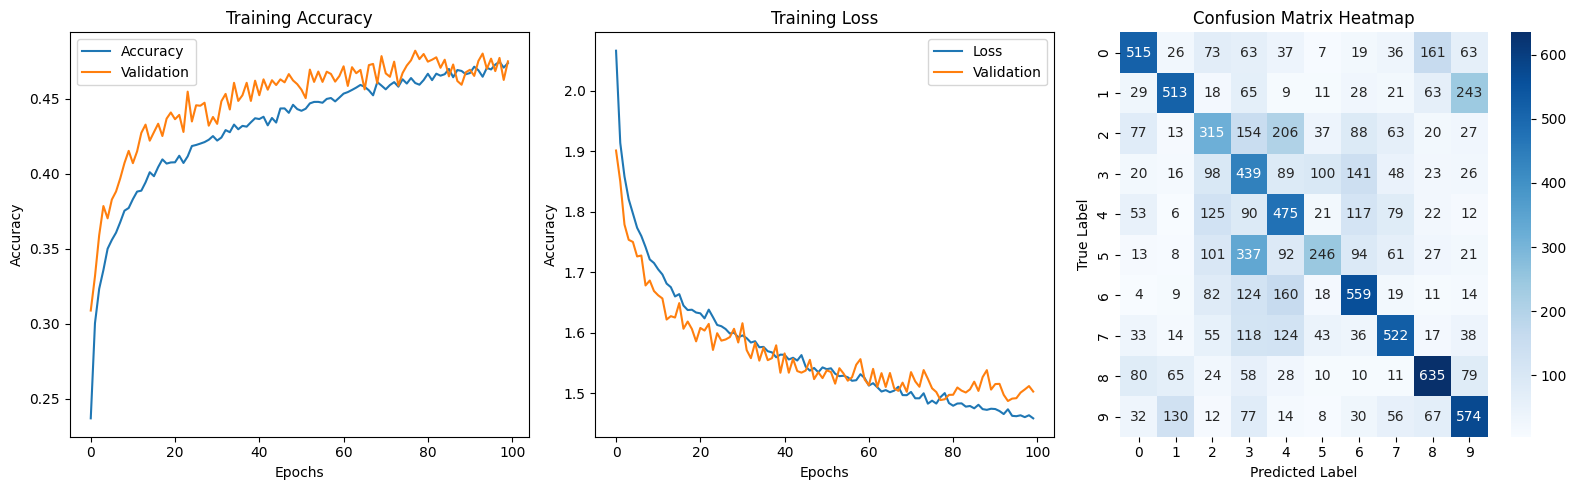

In [16]:
print("3 Dense Layered Model with Dropout")
disp_performance(model_dense_dropout, history)

#### 5.2.3 Increasing ```Dropout``` rates deeper into the network
Whilst adding a ```Dropout``` layer between each ```Dense``` layer significantly improved the loss, it was noted that there was no significant improvement to the accuracy. The following point on dropout rates were noted in an article. ( **<a href="https://medium.com/biased-algorithms/the-role-of-dropout-in-neural-networks-fffbaa77eee7#:~:text=Network%20Size%20and%20Depth:%20Deep%20architectures%20like,overfit%20due%20to%20their%20massive%20parameter%20space.">5 Yadav, 2024</a>** )

> "Deep architectures like ResNet or transformers often benefit from a higher dropout rate (around 0.5) in fully connected layers, as these networks have a tendency to overfit due to their massive parameter space."

As such progressively increasing the dropout rate in deeper layers were implemented to counteract the risk of overfitting. The earlier layers began with a dropout rate of 0.3 to preserve some essential feature learning, whilst deeper layers incorporated a progressively higher dropout rate to improve the generalisation of the model. To do so, more ```Dense``` layers are also included.

In [17]:
model_dense_dropout2 = models.Sequential([
    layers.Dense(1024, activation = "relu", input_shape = (32*32*3,)),
    layers.Dropout(0.2),
    layers.Dense(512, activation = "relu"),
    layers.Dropout(0.25),
    layers.Dense(256, activation = "relu"),
    layers.Dropout(0.3),
    layers.Dense(128, activation = "relu"),
    layers.Dropout(0.35),
    layers.Dense(64, activation = "relu"),
    layers.Dropout(0.4),
    layers.Dense(10, activation = "softmax") # 10 classes
])

model_dense_dropout2.compile( optimizer = "Adam", loss = "categorical_crossentropy", metrics = ["accuracy"] )
history = model_dense_dropout2.fit(x_train, y_train, epochs = 100, batch_size = 128, validation_split = 0.2)

Epoch 1/100


C:\Users\sbgka\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.1239 - loss: 2.3183 - val_accuracy: 0.1886 - val_loss: 2.0553
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.1936 - loss: 2.0855 - val_accuracy: 0.2598 - val_loss: 1.9743
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.2351 - loss: 1.9988 - val_accuracy: 0.2811 - val_loss: 1.9324
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.2616 - loss: 1.9575 - val_accuracy: 0.3130 - val_loss: 1.8798
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.2815 - loss: 1.9196 - val_accuracy: 0.3330 - val_loss: 1.8416
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.2967 - loss: 1.8911 - val_accuracy: 0.3364 - val_loss: 1.8157
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.2988 - loss: 1.8911 - val_accuracy: 0.3453 - val_loss: 1.8263
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.3123 - loss: 1.8699 - val_accuracy

3 Dense Layered Model with Improved Dropout
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4542 - loss: 1.5375
Test Accuracy: 0.45019999146461487
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.43      0.48      1000
           1       0.58      0.58      0.58      1000
           2       0.32      0.20      0.25      1000
           3       0.27      0.40      0.32      1000
           4       0.41      0.33      0.37      1000
           5       0.42      0.29      0.35      1000
           6       0.45      0.58      0.51      1000
           7       0.52      0.51      0.52      1000
           8       0.53      0.66      0.59      1000
           9       0.50      0.51      0.51      1000

    accuracy                           0.45     10000
   macro avg       0.45      0.45      0.45     10000
weighted avg       0.45      0.45      0.45     10000



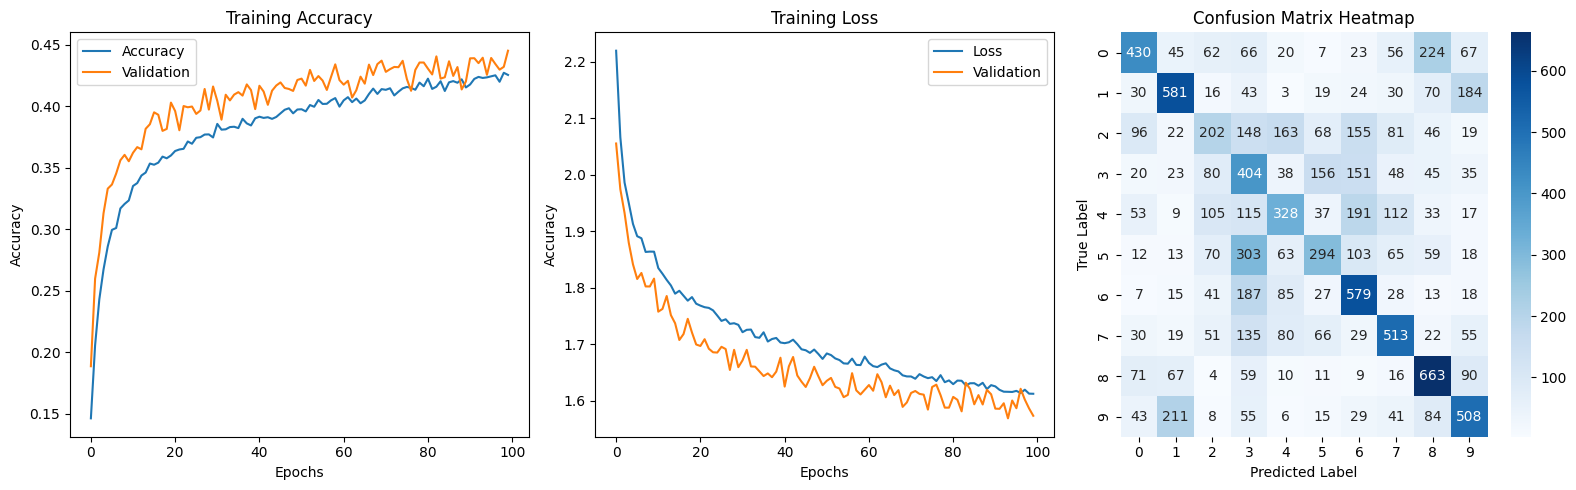

In [18]:
print("Dense Layered Model with Improved Dropout")
disp_performance(model_dense_dropout2, history)

#### 5.2.4 Adding optimizer's learning rate decay
To further stabilise the learning process, a decay is implemented to modify the learning rate from the default 0.001 to 0.0005. It is also noted that classes 2, 3 and 4 have a low recall, suggesting that the model is not identifying the classes well. This could be due to the loss of features in deeper layers. As such these 2 improvements will be done. Note that to prevent the loss of important features, the first ```Dense``` layer will not have a ```Dropout```.

With this being implemented, an accuracy of 0.50 was reachieved with a significantly lower loss.

In [23]:
model_opdecay = models.Sequential([
    layers.Dense(1024, activation = "relu", input_shape = (32*32*3,)),
    layers.Dense(512, activation = "relu"),
    layers.Dropout(0.3),
    layers.Dense(256, activation = "relu"),
    layers.Dropout(0.4),
    layers.Dense(128, activation = "relu"),
    layers.Dropout(0.5),
    layers.Dense(10, activation = "softmax") # 10 classes
])

model_opdecay.compile( optimizer = Adam(learning_rate = 0.001, decay = 1e-5),
                       loss = "categorical_crossentropy", metrics = ["accuracy"] )
history = model_opdecay.fit(x_train, y_train, epochs = 100, batch_size = 128, validation_split = 0.2)

Epoch 1/100


C:\Users\sbgka\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\sbgka\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.1504 - loss: 2.2976 - val_accuracy: 0.2947 - val_loss: 1.9161
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.2883 - loss: 1.9373 - val_accuracy: 0.3560 - val_loss: 1.7885
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.3432 - loss: 1.8251 - val_accuracy: 0.3639 - val_loss: 1.7553
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.3722 - loss: 1.7600 - val_accuracy: 0.3846 - val_loss: 1.7024
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.3836 - loss: 1.7236 - val_accuracy: 0.3957 - val_loss: 1.6693
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.3950 - loss: 1.6760 - val_accuracy: 0.4062 - val_loss: 1.6464
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.4081 - loss: 1.6555 - val_accuracy: 0.4111 - val_loss: 1.6202
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.4204 - loss: 1.6194 - val_accuracy

3 Dense Layered Model with Optimizer Decay
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5034 - loss: 1.4678
Test Accuracy: 0.5020999908447266
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.55      0.56      1000
           1       0.61      0.62      0.61      1000
           2       0.42      0.32      0.36      1000
           3       0.33      0.29      0.31      1000
           4       0.44      0.45      0.44      1000
           5       0.44      0.42      0.43      1000
           6       0.51      0.60      0.55      1000
           7       0.51      0.57      0.54      1000
           8       0.63      0.63      0.63      1000
           9       0.53      0.57      0.55      1000

    accuracy                           0.50     10000
   macro avg       0.50      0.50      0.50     10000
weighted avg       0.50      0.50      0.50     10000



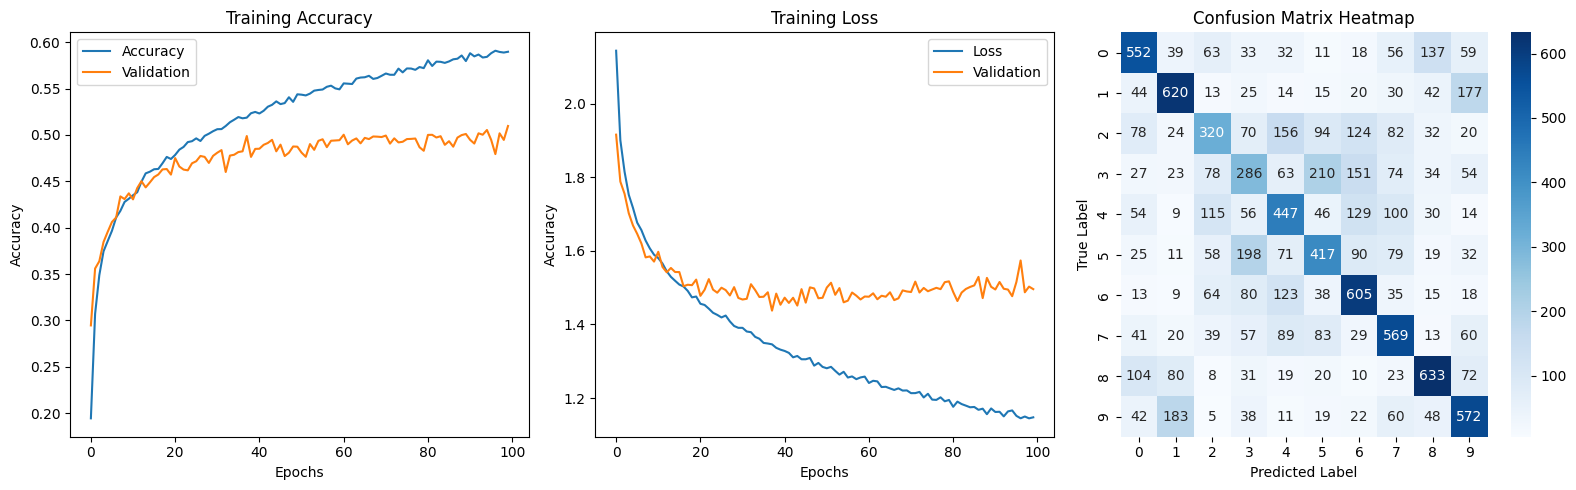

In [24]:
print("Dense Layered Model with Optimizer Decay")
disp_performance(model_opdecay, history)

## 6 Scaling up: developing a model that overfits
To understand how big of a model is required to properly handle the problem, a model will be developed to overfit. Overfitting happens when the model is overoptimizing on the training data. This is visible when the accuracy and loss is seen to increase and decrease with every epoch respectively, but the validation loss and accuracy starts to degrade.

There are different strategies to scaling up, each method will be tested separately.

#### TO BE DELETED
```Once you’ve obtained a model that has statistical power, the question becomes, is your model sufficiently powerful? Does it have enough layers and parameters to properly model the problem at hand? For instance, a network with a single hidden layer with two units would have statistical power on MNIST but wouldn’t be sufficient to solve the problem well. Remember that the universal tension in machine learning is between optimization and generalization; the ideal model is one that stands right at the border between underfitting and overfitting; between undercapacity and overcapacity. To figure out where this border lies, first you must cross it.```

```To figure out how big a model you’ll need, you must develop a model that overfits. This is fairly easy:```
1. Add layers
2. Make the layers bigger
3. Train for more epochs

```Always monitor the training loss and validation loss, as well as the training and validation values for any metrics you care about. When you see that the model’s performance on the validation data begins to degrade, you’ve achieved overfitting.```

```The next stage is to start regularizing and tuning the model, to get as close as possible to the ideal model that neither underfits nor overfits.```

### 6.1 Adding more ```Dense``` layers
To overfit the data with more ```Dense``` layers, each ```Dense``` layer is duplicated.

In [10]:
model_of_layers = models.Sequential([
    layers.Dense(1024, activation = "relu", input_shape = (32*32*3,)),
    layers.Dense(1024, activation = "relu"),
    layers.Dense(512, activation = "relu"),
    layers.Dense(512, activation = "relu"),
    layers.Dense(256, activation = "relu"),
    layers.Dense(256, activation = "relu"),
    layers.Dropout(0.3),
    layers.Dense(128, activation = "relu"),
    layers.Dropout(0.4),
    layers.Dense(128, activation = "relu"),
    layers.Dropout(0.5),
    layers.Dense(10, activation = "softmax") # 10 classes
])

model_of_layers.compile( optimizer = Adam(learning_rate = 0.001, decay = 1e-5),
                         loss = "categorical_crossentropy", metrics = ["accuracy"] )
history = model_of_layers.fit(x_train, y_train, epochs = 100, batch_size = 128, validation_split = 0.2)

Epoch 1/100


C:\Users\sbgka\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\sbgka\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.1327 - loss: 2.2504 - val_accuracy: 0.1978 - val_loss: 2.0518
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.2167 - loss: 2.0153 - val_accuracy: 0.2839 - val_loss: 1.9028
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.2799 - loss: 1.9163 - val_accuracy: 0.3150 - val_loss: 1.8135
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.3108 - loss: 1.8410 - val_accuracy: 0.3322 - val_loss: 1.7746
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.3269 - loss: 1.8102 - val_accuracy: 0.3558 - val_loss: 1.7477
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.3548 - loss: 1.7460 - val_accuracy: 0.3465 - val_loss: 1.7972
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.3591 - loss: 1.7375 - val_accuracy: 0.3701 - val_loss: 1.7170
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.3905 - loss: 1.6900 - val_accuracy

Dense Layer Model - Overfitted
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4459 - loss: 3.4101
Test Accuracy: 0.4453999996185303
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.54      0.53      1000
           1       0.52      0.55      0.54      1000
           2       0.36      0.30      0.33      1000
           3       0.28      0.32      0.30      1000
           4       0.39      0.36      0.37      1000
           5       0.37      0.37      0.37      1000
           6       0.43      0.45      0.44      1000
           7       0.54      0.48      0.51      1000
           8       0.56      0.64      0.60      1000
           9       0.49      0.45      0.47      1000

    accuracy                           0.45     10000
   macro avg       0.45      0.45      0.44     10000
weighted avg       0.45      0.45      0.44     10000



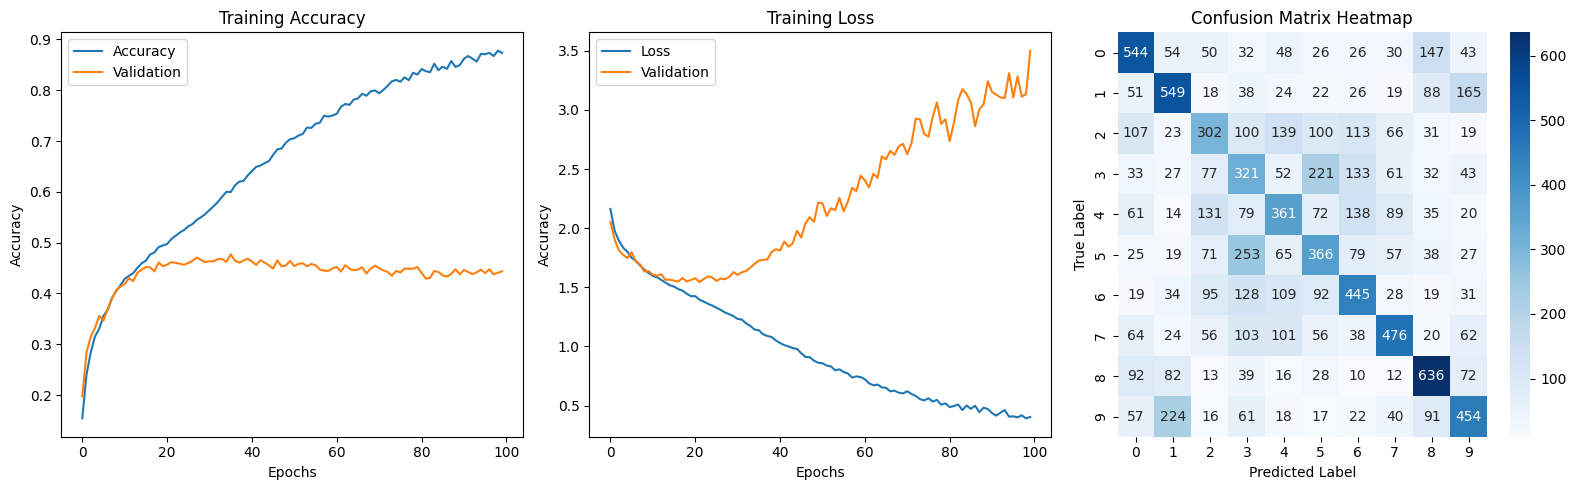

In [11]:
print("Dense Layer Model - Overfitted")
disp_performance(model_of_layers, history)

With this, the model is seen to overfit from the training accuracy reaching 0.8735 in the last epoch but the validation accuracy reaching 0.4707 at epoch 28, then stagnating. This is also visible from the training loss decreasing to 0.4083, but the validation loss dipping to 1.5447 at epoch 22, then begining to climb to 3.5002. To overcome this, the first 3 duplicated ```Dense``` layers will be removed.

In [12]:
model_of_layers2 = models.Sequential([
    layers.Dense(1024, activation = "relu", input_shape = (32*32*3,)),
    layers.Dense(512, activation = "relu"),
    layers.Dense(256, activation = "relu"),
    layers.Dropout(0.3),
    layers.Dense(128, activation = "relu"),
    layers.Dropout(0.4),
    layers.Dense(128, activation = "relu"),
    layers.Dropout(0.5),
    layers.Dense(10, activation = "softmax") # 10 classes
])

model_of_layers2.compile( optimizer = Adam(learning_rate = 0.001, decay = 1e-5),
                          loss = "categorical_crossentropy", metrics = ["accuracy"] )
history = model_of_layers2.fit(x_train, y_train, epochs = 100, batch_size = 128, validation_split = 0.2)

Epoch 1/100


C:\Users\sbgka\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\sbgka\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.1395 - loss: 2.2797 - val_accuracy: 0.2442 - val_loss: 1.9610
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.2613 - loss: 1.9583 - val_accuracy: 0.3205 - val_loss: 1.8542
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.3220 - loss: 1.8627 - val_accuracy: 0.3375 - val_loss: 1.8327
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.3472 - loss: 1.8206 - val_accuracy: 0.3798 - val_loss: 1.7185
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.3743 - loss: 1.7518 - val_accuracy: 0.3768 - val_loss: 1.7220
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.3868 - loss: 1.7208 - val_accuracy: 0.3997 - val_loss: 1.6909
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.4036 - loss: 1.6782 - val_accuracy: 0.3948 - val_loss: 1.6689
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.4113 - loss: 1.6534 - val_accuracy

Dense Layer Model - Overfitted (Reduced)
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4790 - loss: 1.9332
Test Accuracy: 0.48240000009536743
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.55      0.55      1000
           1       0.62      0.58      0.60      1000
           2       0.38      0.35      0.36      1000
           3       0.30      0.32      0.31      1000
           4       0.44      0.37      0.40      1000
           5       0.39      0.37      0.38      1000
           6       0.51      0.57      0.54      1000
           7       0.51      0.56      0.53      1000
           8       0.55      0.68      0.61      1000
           9       0.57      0.49      0.52      1000

    accuracy                           0.48     10000
   macro avg       0.48      0.48      0.48     10000
weighted avg       0.48      0.48      0.48     10000



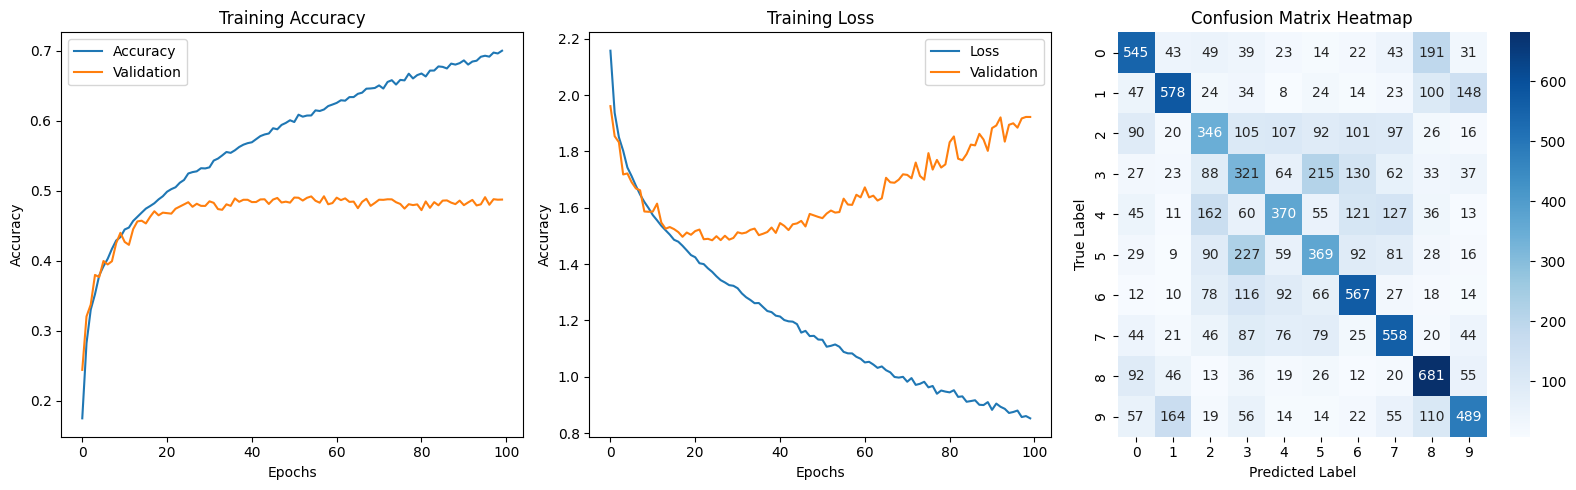

In [13]:
print("Dense Layer Model - Overfitted (Reduced)")
disp_performance(model_of_layers2, history)

After reducing the number of ```Dense``` layers, some improvements were observed, but overfitting is still present. Whilst the training accuracy reaches to 0.7008, lower than the previous 0.8735, the validation accuracy reached 0.4837 in epoch 26 before starting to stagnate. In addition, the training loss increased to 0.8511 from the previous 0.4083. However, the validation loss dipped to 1.4848 at epoch 25 before climbing to 1.9226. This displayed a significant improvement in reducing the validation loss. (3.5002 spike reduced to 1.9226 spike)

In addition, with the following data:

Dense Layer Model - Overfitted
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4459 - loss: 3.4101
Test Accuracy: 0.4453999996185303
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Dense Layer Model - Overfitted (Reduced)
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4790 - loss: 1.9332
Test Accuracy: 0.48240000009536743
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

It is seen that the reduced layers improved the test accuracy and loss, thus proving the efficacy.

### 6.2 Making layers denser
To test overfitting more aggressively, the next stage is to apply denser layers, this would include making the current ```Dense``` layers denser to encourage overfitting. After implementing denser layers, attempts to improve the model will be made.

In [6]:
model_of_denser = models.Sequential([
    layers.Dense(2048, activation = "relu", input_shape = (32*32*3,)),
    layers.Dense(1024, activation = "relu"),
    layers.Dense(512, activation = "relu"),
    layers.Dropout(0.3),
    layers.Dense(256, activation = "relu"),
    layers.Dropout(0.4),
    layers.Dense(128, activation = "relu"),
    layers.Dropout(0.5),
    layers.Dense(10, activation = "softmax") # 10 classes
])

model_of_denser.compile( optimizer = Adam(learning_rate = 0.001, decay = 1e-5),
                         loss = "categorical_crossentropy", metrics = ["accuracy"] )
history = model_of_denser.fit(x_train, y_train, epochs = 100, batch_size = 128, validation_split = 0.2)

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.1381 - loss: 2.3158 - val_accuracy: 0.2649 - val_loss: 1.9634
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.2773 - loss: 1.9363 - val_accuracy: 0.3520 - val_loss: 1.7954
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.3270 - loss: 1.8437 - val_accuracy: 0.3507 - val_loss: 1.7934
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.3549 - loss: 1.7854 - val_accuracy: 0.3559 - val_loss: 1.7675
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.3725 - loss: 1.7446 - val_accuracy: 0.3873 - val_loss: 1.6925
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.3965 - loss: 1.6901 - val_accuracy: 0.4085 - val_loss: 1.6419
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.4077 - loss: 1.6614 - val_accuracy: 0.4104 - val_loss: 1.6258
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.4171 - loss: 1.6302 

Dense Layer Model - Overfitted (Denser)
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4785 - loss: 2.3955
Test Accuracy: 0.4788999855518341
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.53      0.56      1000
           1       0.63      0.56      0.59      1000
           2       0.36      0.31      0.33      1000
           3       0.32      0.31      0.32      1000
           4       0.39      0.39      0.39      1000
           5       0.40      0.39      0.40      1000
           6       0.46      0.60      0.52      1000
           7       0.55      0.53      0.54      1000
           8       0.56      0.63      0.60      1000
           9       0.54      0.52      0.53      1000

    accuracy                           0.48     10000
   macro avg       0.48      0.48      0.48     10000
weighted avg       0.48      0.48      0.48     10000



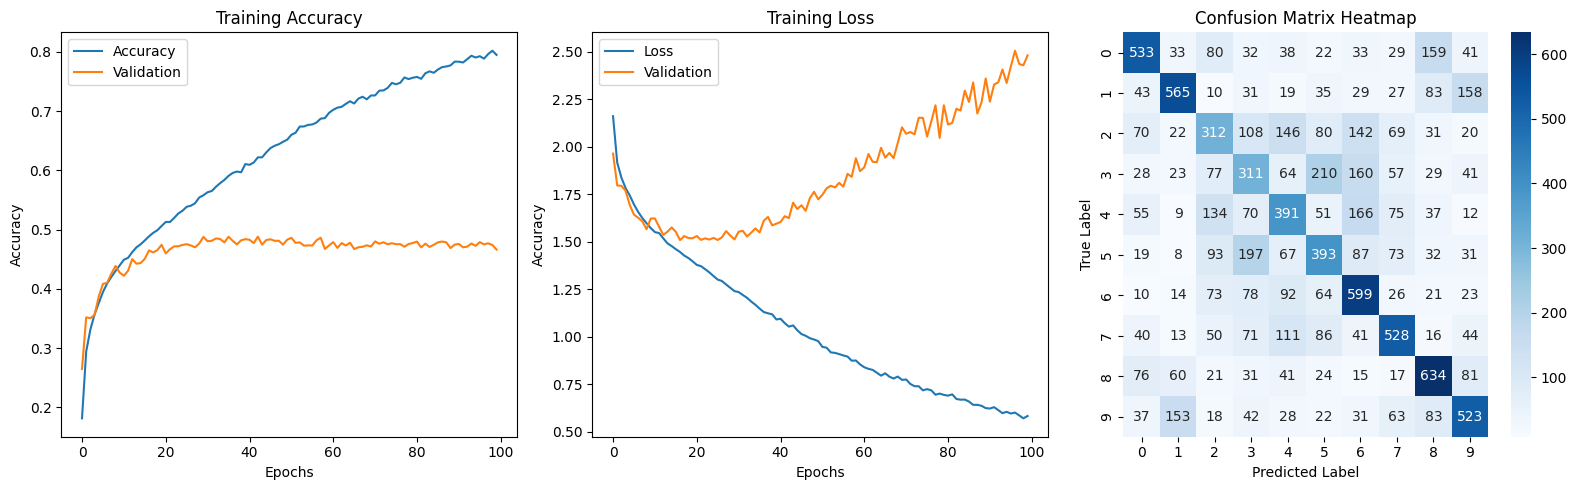

In [7]:
print("Dense Layer Model - Overfitted (Denser)")
disp_performance(model_of_denser, history)

With this, the model still exhibits overfitting. Whilst the denser layers achieved a better training accuracy of 0.7992, the validation accuracy peaked at 0.4878 at epoch 30 before stagnating. In addition, whilst the training loss decreased to 0.5760, the validation loss dipped to 1.5080 at epoch 17 before starting to peak. The validation loss also worsened from 1.9226 to 2.4802.

### 6.3 Modifying dropout rate
To overcome this, the dropout rate in the earlier layers will be reduced to allow the network to retain more learned features before regularising in later layers. This is to prevent over-generalisation too early into the model's training.

In [8]:
model_of_denser2 = models.Sequential([
    layers.Dense(2048, activation = "relu", input_shape = (32*32*3,)),
    layers.Dense(1024, activation = "relu"),
    layers.Dense(512, activation = "relu"),
    layers.Dropout(0.2),
    layers.Dense(256, activation = "relu"),
    layers.Dropout(0.3),
    layers.Dense(128, activation = "relu"),
    layers.Dropout(0.5),
    layers.Dense(10, activation = "softmax") # 10 classes
])

model_of_denser2.compile( optimizer = Adam(learning_rate = 0.001, decay = 1e-5),
                          loss = "categorical_crossentropy", metrics = ["accuracy"] )
history = model_of_denser2.fit(x_train, y_train, epochs = 100, batch_size = 128, validation_split = 0.2)

Epoch 1/100


C:\Users\sbgka\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\sbgka\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.1570 - loss: 2.2580 - val_accuracy: 0.3035 - val_loss: 1.8872
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.2927 - loss: 1.9195 - val_accuracy: 0.3285 - val_loss: 1.8388
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.3442 - loss: 1.8076 - val_accuracy: 0.3697 - val_loss: 1.7421
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.3711 - loss: 1.7496 - val_accuracy: 0.3811 - val_loss: 1.7147
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.3997 - loss: 1.6887 - val_accuracy: 0.4171 - val_loss: 1.6453
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.4163 - loss: 1.6458 - val_accuracy: 0.4280 - val_loss: 1.6026
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.4326 - loss: 1.6038 - val_accuracy: 0.4348 - val_loss: 1.5725
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.4429 - loss: 1.5715 - val_accurac

Dense Layer Model - Denser (Red. Early Dropout)
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4889 - loss: 2.8050
Test Accuracy: 0.4864000082015991
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.60      0.57      1000
           1       0.62      0.60      0.61      1000
           2       0.37      0.37      0.37      1000
           3       0.31      0.34      0.33      1000
           4       0.40      0.38      0.39      1000
           5       0.38      0.36      0.37      1000
           6       0.54      0.54      0.54      1000
           7       0.56      0.53      0.54      1000
           8       0.58      0.65      0.61      1000
           9       0.56      0.50      0.53      1000

    accuracy                           0.49     10000
   macro avg       0.49      0.49      0.49     10000
weighted avg       0.49      0.49      0.49     10000



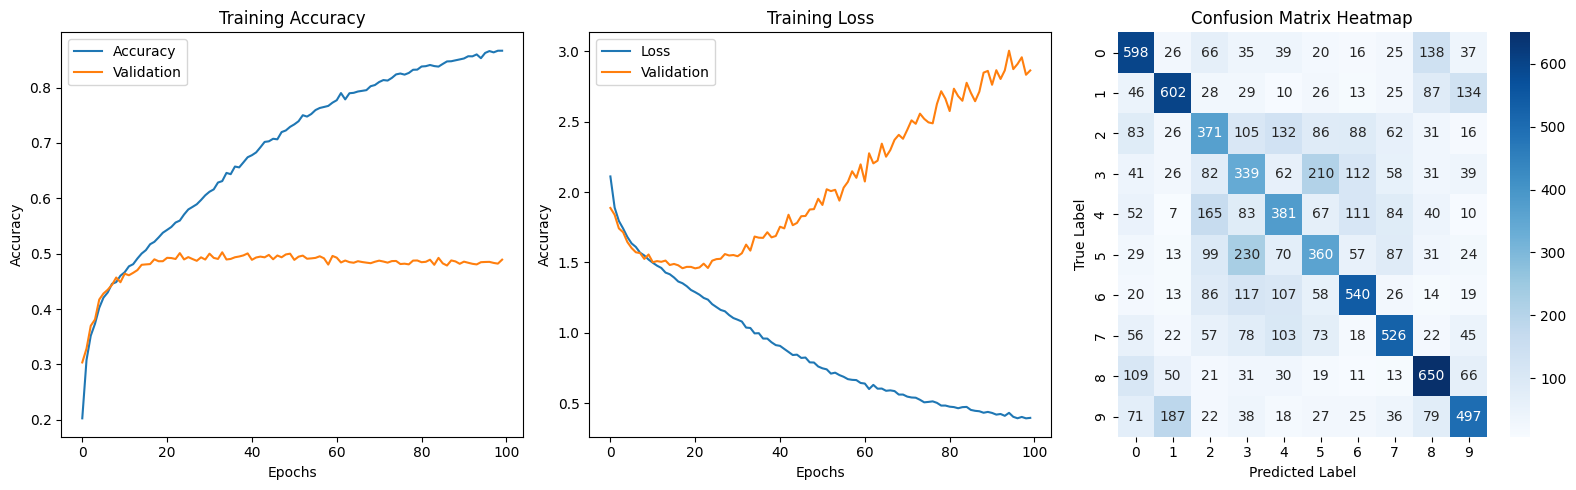

In [9]:
print("Dense Layer Model - Denser (Red. Early Dropout)")
disp_performance(model_of_denser2, history)

With the reduction of early dropout rates, it the model had some slight improvements.

The introduction of an early dropout rate caused a training accuracy of 0.8717 as compared to the previous 0.7992, and the training loss decreased to 0.3821 from the previous 0.5760. The testing accuracy increased to 0.4889 from an original 0.4785, but the testing loss increased to 2.8050 from an original of 2.3955. In addition, the validation accuracy hit 0.5010 in epoch 24 before stagnating, and the validation loss dipped to 1.4590 in epoch 18 before rising to 2.8050.

As such, the next step would be to keep the original early dropout rates but increasing the dropout rate in later layers to force generalisation.

In [10]:
model_of_denser3 = models.Sequential([
    layers.Dense(2048, activation = "relu", input_shape = (32*32*3,)),
    layers.Dense(1024, activation = "relu"),
    layers.Dense(512, activation = "relu"),
    layers.Dropout(0.3),
    layers.Dense(256, activation = "relu"),
    layers.Dropout(0.4),
    layers.Dense(128, activation = "relu"),
    layers.Dropout(0.6),
    layers.Dense(10, activation = "softmax") # 10 classes
])

model_of_denser3.compile( optimizer = Adam(learning_rate = 0.001, decay = 1e-5),
                          loss = "categorical_crossentropy", metrics = ["accuracy"] )
history = model_of_denser3.fit(x_train, y_train, epochs = 100, batch_size = 128, validation_split = 0.2)

Epoch 1/100


C:\Users\sbgka\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\sbgka\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.1368 - loss: 2.3246 - val_accuracy: 0.2688 - val_loss: 1.9532
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.2663 - loss: 1.9738 - val_accuracy: 0.3235 - val_loss: 1.8606
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.3185 - loss: 1.8875 - val_accuracy: 0.3566 - val_loss: 1.7877
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.3497 - loss: 1.8122 - val_accuracy: 0.3827 - val_loss: 1.7192
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.3724 - loss: 1.7546 - val_accuracy: 0.3956 - val_loss: 1.6707
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.3905 - loss: 1.7101 - val_accuracy: 0.3872 - val_loss: 1.6866
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.4046 - loss: 1.6772 - val_accuracy: 0.4133 - val_loss: 1.6303
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.4130 - loss: 1.6465 - val_a

Dense Layer Model - Denser (Inc. Later Dropout)
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4735 - loss: 2.2202
Test Accuracy: 0.47369998693466187
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.55      0.56      1000
           1       0.59      0.54      0.57      1000
           2       0.36      0.34      0.35      1000
           3       0.32      0.29      0.31      1000
           4       0.38      0.45      0.41      1000
           5       0.39      0.39      0.39      1000
           6       0.51      0.51      0.51      1000
           7       0.51      0.53      0.52      1000
           8       0.60      0.60      0.60      1000
           9       0.52      0.53      0.52      1000

    accuracy                           0.47     10000
   macro avg       0.47      0.47      0.47     10000
weighted avg       0.47      0.47      0.47     10000



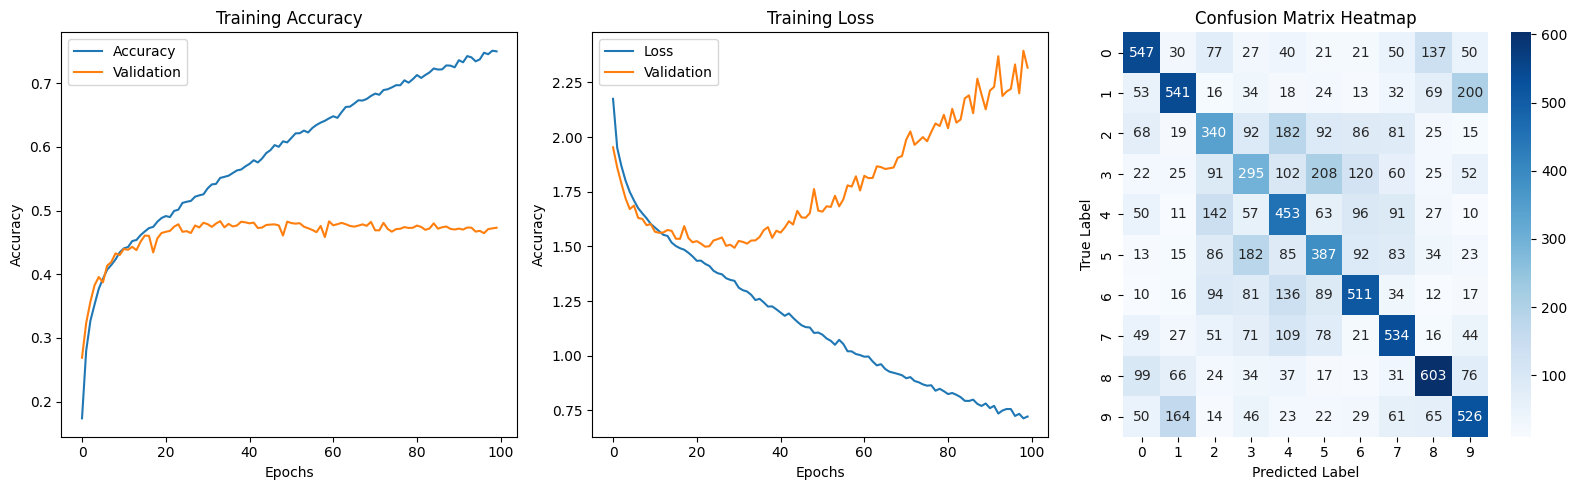

In [11]:
print("Dense Layer Model - Denser (Inc. Later Dropout)")
disp_performance(model_of_denser3, history)

With increasing later dropout rates, the model is seen to perform worse. The training accuracy dropped to 0.7540 from an original 0.7992, and the loss increased to 0.7057 from an original of 0.5760. In addition, the validation accuracy hit 0.4747 in epoch 23 before stagnating, and the validation loss dipped to 1.4936 in epoch 30 before starting to rise to 2.3179.

However, to test the model's capabilities, the combination of a lower early dropout rate with a higher later dropout rate will be done. This is because lower early dropout rates will help the model to learn richer feature representations whilst higher later dropout rates help to prevent overfitting in deeper layers by forcing generalisation. In theory, the combination of both should produce a better performing model.

In [13]:
model_of_denser4 = models.Sequential([
    layers.Dense(2048, activation = "relu", input_shape = (32*32*3,)),
    layers.Dense(1024, activation = "relu"),
    layers.Dense(512, activation = "relu"),
    layers.Dropout(0.2),
    layers.Dense(256, activation = "relu"),
    layers.Dropout(0.4),
    layers.Dense(128, activation = "relu"),
    layers.Dropout(0.6),
    layers.Dense(10, activation = "softmax") # 10 classes
])

model_of_denser4.compile( optimizer = Adam(learning_rate = 0.001, decay = 1e-5),
                          loss = "categorical_crossentropy", metrics = ["accuracy"] )
history = model_of_denser4.fit(x_train, y_train, epochs = 100, batch_size = 128, validation_split = 0.2)

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.1356 - loss: 2.3236 - val_accuracy: 0.2636 - val_loss: 1.9772
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.2621 - loss: 1.9754 - val_accuracy: 0.3265 - val_loss: 1.8535
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.3212 - loss: 1.8682 - val_accuracy: 0.3617 - val_loss: 1.7605
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.3508 - loss: 1.8092 - val_accuracy: 0.3751 - val_loss: 1.7304
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.3691 - loss: 1.7653 - val_accuracy: 0.3951 - val_loss: 1.6674
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.3962 - loss: 1.6972 - val_accuracy: 0.4029 - val_loss: 1.6737
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.4074 - loss: 1.6658 - val_accuracy: 0.3974 - val_loss: 1.6603
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.4202 - loss: 1.6313

Dense Layer Model - Denser (Dropout Mods.)
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4899 - loss: 2.6100
Test Accuracy: 0.4832000136375427
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.57      0.57      1000
           1       0.60      0.55      0.58      1000
           2       0.38      0.29      0.33      1000
           3       0.31      0.34      0.32      1000
           4       0.39      0.38      0.39      1000
           5       0.42      0.35      0.38      1000
           6       0.50      0.53      0.52      1000
           7       0.51      0.61      0.55      1000
           8       0.58      0.64      0.61      1000
           9       0.53      0.56      0.55      1000

    accuracy                           0.48     10000
   macro avg       0.48      0.48      0.48     10000
weighted avg       0.48      0.48      0.48     10000



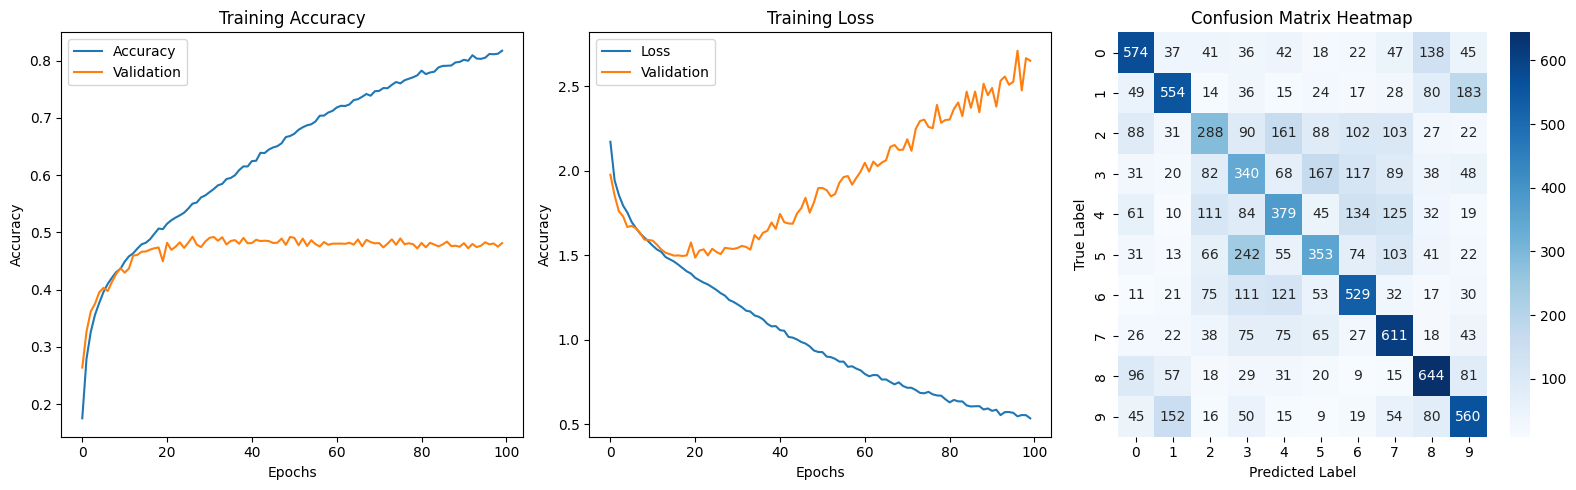

In [16]:
print("Dense Layer Model - Denser (Dropout Mods.)")
disp_performance(model_of_denser4, history)

With the implementation of both modifications, it is recognised that the best implementation was the introduction of both a reduced early dropout rate and an increased later dropout rate. The model reached a training accuracy of 0.8199 and training loss of 0.5327. The validation accuracy reached 0.4819 in epoch 21 before stagnating, and the validation loss dipped to 1.4958 in epoch 18 before increasing.

Dense Layer Model - Overfitted (Denser)
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4785 - loss: 2.3955
<br>Test Accuracy: 0.4788999855518341
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Dense Layer Model - Denser (Red. Early Dropout)
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4889 - loss: 2.8050
<br>Test Accuracy: 0.4864000082015991
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Dense Layer Model - Denser (Inc. Later Dropout)
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4735 - loss: 2.2202
<br>Test Accuracy: 0.47369998693466187
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Dense Layer Model - Denser (Dropout Mods.)
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4899 - loss: 2.6100
<br>Test Accuracy: 0.4832000136375427
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

### 6.4 Implementing early stopping
After analysing the performance of the model with denser layers and various dropout rate configurations, it is evident that overfitting has occurred too early in the training process. The training accuracy is seen to continue improving, but the validation accuracy stagnates, and the validation loss starts to rise significantly.

To prevent this, early stopping is introduced to halt training once validation loss stops improving, preventing any unnecessary overfitting to ensure that the model maintains the best generalisation performance whilst avoiding overtraining that can lead to performance degradation on the unseen testing data.

- ```monitor = "val_loss"```: stops training when the validation loss stops decreasing
- ```patience = 10```: checks how many epochs the validation loss stops improving
- ```restore_best_weight```: restores the model weights from the best epoch before stopping
- ```verbose = 1```: helps to print a message when early stopping has occurred

In [21]:
early_stopping = EarlyStopping(monitor = "val_loss", patience = 10, restore_best_weights = True, verbose = 1)

model_early_stop = models.Sequential([
    layers.Dense(2048, activation = "relu", input_shape = (32*32*3,)),
    layers.Dense(1024, activation = "relu"),
    layers.Dense(512, activation = "relu"),
    layers.Dropout(0.2),
    layers.Dense(256, activation = "relu"),
    layers.Dropout(0.4),
    layers.Dense(128, activation = "relu"),
    layers.Dropout(0.6),
    layers.Dense(10, activation = "softmax") # 10 classes
])

model_early_stop.compile( optimizer = Adam(learning_rate = 0.001, decay = 1e-5),
                          loss = "categorical_crossentropy", metrics = ["accuracy"] )
history = model_early_stop.fit(x_train, y_train, epochs = 100, batch_size = 128, validation_split = 0.2, callbacks = [early_stopping])

C:\Users\sbgka\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\sbgka\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - accuracy: 0.1400 - loss: 2.3249 - val_accuracy: 0.2661 - val_loss: 1.9748
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.2654 - loss: 1.9646 - val_accuracy: 0.3164 - val_loss: 1.8619
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - accuracy: 0.3305 - loss: 1.8581 - val_accuracy: 0.3666 - val_loss: 1.7677
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - accuracy: 0.3596 - loss: 1.7834 - val_accuracy: 0.3766 - val_loss: 1.7078
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - accuracy: 0.3788 - loss: 1.7338 - val_accuracy: 0.3922 - val_loss: 1.6668
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - accuracy: 0.4002 - loss: 1.6967 - val_accuracy: 0.3965 - val_loss: 1.6999
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - accuracy: 0.4140 - loss: 1.6547 - val_accuracy: 0.4171 - val_loss: 1.6168
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - accuracy: 0.4163 - loss: 1

Dense Layer Model - Early Stopping
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4887 - loss: 1.4533
Test Accuracy: 0.49059998989105225
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.61      0.55      1000
           1       0.61      0.64      0.62      1000
           2       0.39      0.28      0.33      1000
           3       0.34      0.37      0.35      1000
           4       0.41      0.49      0.45      1000
           5       0.44      0.33      0.37      1000
           6       0.54      0.51      0.52      1000
           7       0.56      0.51      0.53      1000
           8       0.56      0.66      0.60      1000
           9       0.55      0.52      0.53      1000

    accuracy                           0.49     10000
   macro avg       0.49      0.49      0.49     10000
weighted avg       0.49      0.49      0.49     10000



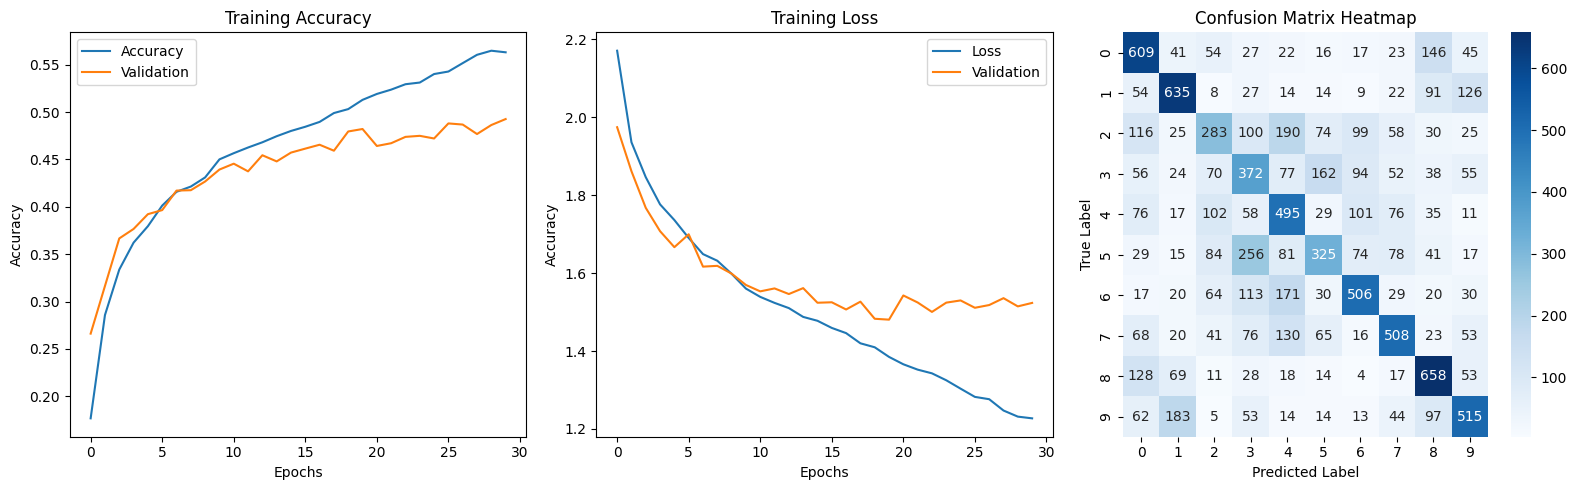

In [22]:
print("Dense Layer Model - Early Stopping")
disp_performance(model_early_stop, history)

With this, it is noted that the validation loss has stopped spiking after staying stagnant. This has helped improve the model by reducing the gap between the training loss and validation loss. With previous implementation, the training loss reached 0.5327 whilst the validation loss rose to 2.6526. With the new implementation. Whilst the training loss is at 1.2036, the validation loss stopped at 1.5237.

An attempt to reduce the ```patience``` value to 5 will now be done to check for any improvements to the model's performance.

In [23]:
early_stopping = EarlyStopping(monitor = "val_loss", patience = 5, restore_best_weights = True, verbose = 1)

model_early_stop2 = models.Sequential([
    layers.Dense(2048, activation = "relu", input_shape = (32*32*3,)),
    layers.Dense(1024, activation = "relu"),
    layers.Dense(512, activation = "relu"),
    layers.Dropout(0.2),
    layers.Dense(256, activation = "relu"),
    layers.Dropout(0.4),
    layers.Dense(128, activation = "relu"),
    layers.Dropout(0.6),
    layers.Dense(10, activation = "softmax") # 10 classes
])

model_early_stop2.compile( optimizer = Adam(learning_rate = 0.001, decay = 1e-5),
                           loss = "categorical_crossentropy", metrics = ["accuracy"] )
history = model_early_stop2.fit(x_train, y_train, epochs = 100, batch_size = 128, validation_split = 0.2, callbacks = [early_stopping])

C:\Users\sbgka\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\sbgka\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - accuracy: 0.1374 - loss: 2.3234 - val_accuracy: 0.2793 - val_loss: 1.9441
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.2692 - loss: 1.9581 - val_accuracy: 0.3347 - val_loss: 1.8274
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.3192 - loss: 1.8742 - val_accuracy: 0.3671 - val_loss: 1.7689
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - accuracy: 0.3451 - loss: 1.8040 - val_accuracy: 0.3808 - val_loss: 1.7229
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.3736 - loss: 1.7567 - val_accuracy: 0.4050 - val_loss: 1.6611
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.4008 - loss: 1.6907 - val_accuracy: 0.4163 - val_loss: 1.6316
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.4135 - loss: 1.6710 - val_accuracy: 0.4092 - val_loss: 1.6459
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.4184 - loss: 1

Dense Layer Model - Early Stopping (Red. Patience)
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4945 - loss: 1.4364
Test Accuracy: 0.4909000098705292
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.53      0.55      1000
           1       0.57      0.64      0.60      1000
           2       0.34      0.36      0.35      1000
           3       0.36      0.33      0.34      1000
           4       0.42      0.35      0.38      1000
           5       0.46      0.29      0.36      1000
           6       0.46      0.63      0.53      1000
           7       0.55      0.56      0.55      1000
           8       0.58      0.66      0.62      1000
           9       0.57      0.56      0.56      1000

    accuracy                           0.49     10000
   macro avg       0.49      0.49      0.49     10000
weighted avg       0.49      0.49      0.49     10000



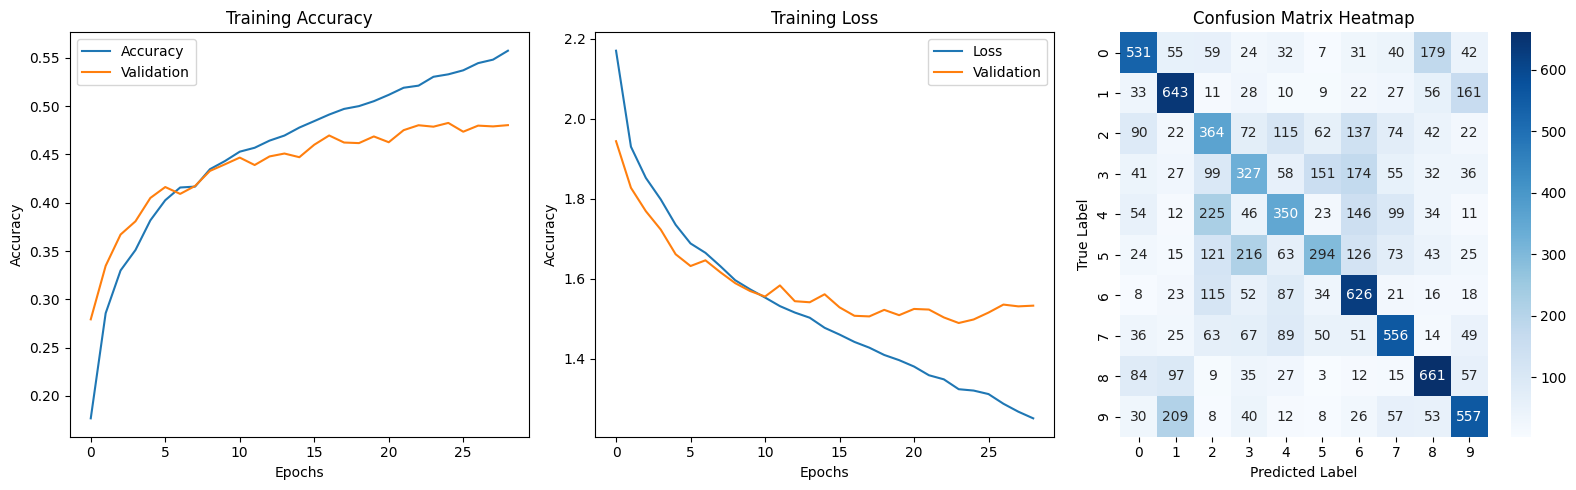

In [24]:
print("Dense Layer Model - Early Stopping (Red. Patience)")
disp_performance(model_early_stop2, history)

With a smaller patience value, it is noted that the model performs better on unseen data, but this improvement is minute. The reduction of patience value increased the test accuracy to 0.4945 from the original 0.4887. In addition the training loss reduced to 1.4364 from the original 1.4533. The minute difference is also evident as the previous model stopped at epoch 30, with epoch 20 performing the best, whereas now the early stopping activates at epoch 29, with epoch 24 performing the best.

### 6.5 Scaling model further
With the implementation of ```EarlyStopping```, it is recognised that the model is now only completing only about 30% of the total training epochs before stopping due to overfitting. This would suggest that the model reaches its optimal performance too early and does not benefit significantly from additional training layers. As such, the model architecture could be further scaled up to improve its performance whilst still identifying the point at which overfitting occurs.

## 7 Regularizing your model and tuning your hyperparameters
```This step will take the most time: you’ll repeatedly modify your model, train it, evaluate on your validation data (not the test data, at this point), modify it again, and repeat, until the model is as good as it can get. These are some things you should try:```

- Add dropout
- Try different architectures: add or remove layers
- Add L1 and/or L2 regularization
- Try different hyperparameters (such as the number of units per layer or the learning rate of the optimizer) to find the optimal configuration
- Optionally, iterate on feature engineering: add new features, or remove features that don’t seem to be informative

```Be mindful of the following: every time you use feedback from your validation process to tune your model, you leak information about the validation process into the model. Repeated just a few times, this is innocuous; but done systematically over many iterations, it will eventually cause your model to overfit to the validation process (even though no model is directly trained on any of the validation data). This makes the evaluation process less reliable.```

```Once you’ve developed a satisfactory model configuration, you can train your final production model on all the available data (training and validation) and evaluate it one last time on the test set. If it turns out that performance on the test set is significantly worse than the performance measured on the validation data, this may mean either that your validation procedure wasn’t reliable after all, or that you began overfitting to the validation data while tuning the parameters of the model. In this case, you may want to switch to a more reliable evaluation protocol (such as iterated K-fold validation).```

## 8 References
1. Keras (n.d.). Keras documentation: CIFAR10 Small Images Classification Dataset. [online] keras.io. Available at: https://keras.io/api/datasets/cifar10/.
2. Bleyer, A. and Welch, H.G. (2012). Effect of Three Decades of Screening Mammography on Breast-Cancer Incidence. New England Journal of Medicine, 367(21), pp.1998–2005. doi:https://doi.org/10.1056/nejmoa1206809.
3. Krizhevsky, A. (2009). CIFAR-10 and CIFAR-100 datasets. [online] Toronto.edu. Available at: https://www.cs.toronto.edu/~kriz/cifar.html.
4. Kingma, D.P. and Ba, J. (2014). Adam: A Method for Stochastic Optimization. [online] arXiv.org. Available at: https://arxiv.org/abs/1412.6980.

In [5]:
model_overfit = models.Sequential([
    layers.Dense(2048, activation = "relu", input_shape = (32*32*3,)),
    layers.Dense(1024, activation = "relu"),
    layers.Dense(512, activation = "relu"),
    layers.Dense(256, activation = "relu"),
    layers.Dense(128, activation = "relu"),
    layers.Dropout(0.3),
    layers.Dense(128, activation = "relu"),
    layers.Dropout(0.4),
    layers.Dense(64, activation = "relu"),
    layers.Dropout(0.5),
    layers.Dense(10, activation = "softmax") # 10 classes
])

model_overfit.compile( optimizer = Adam(learning_rate = 0.001, decay = 1e-5),
                       loss = "categorical_crossentropy", metrics = ["accuracy"] )
history = model_overfit.fit(x_train, y_train, epochs = 1000, batch_size = 128, validation_split = 0.2)

Epoch 1/1000


C:\Users\sbgka\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\sbgka\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - accuracy: 0.1262 - loss: 2.2791 - val_accuracy: 0.1755 - val_loss: 2.0791
Epoch 2/1000
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.1791 - loss: 2.0941 - val_accuracy: 0.1955 - val_loss: 2.0449
Epoch 3/1000
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.1848 - loss: 2.0489 - val_accuracy: 0.1989 - val_loss: 2.0184
Epoch 4/1000
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.1957 - loss: 2.0145 - val_accuracy: 0.1993 - val_loss: 2.0117
Epoch 5/1000
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.2020 - loss: 1.9939 - val_accuracy: 0.2201 - val_loss: 1.9723
Epoch 6/1000
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.2112 - loss: 1.9729 - val_accuracy: 0.2266 - val_loss: 1.9360
Epoch 7/1000
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.2192 - loss: 1.9630 - val_accuracy: 0.2276 - val_loss: 1.9421
Epoch 8/1000
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.2233 - loss: 1.9383 

Dense Layer Model with Overfitting
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1006 - loss: 2.3026
Test Accuracy: 0.10000000149011612
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1000
           1       0.00      0.00      0.00      1000
           2       0.10      1.00      0.18      1000
           3       0.00      0.00      0.00      1000
           4       0.00      0.00      0.00      1000
           5       0.00      0.00      0.00      1000
           6       0.00      0.00      0.00      1000
           7       0.00      0.00      0.00      1000
           8       0.00      0.00      0.00      1000
           9       0.00      0.00      0.00      1000

    accuracy                           0.10     10000
   macro avg       0.01      0.10      0.02     10000
weighted avg       0.01      0.10      0.02     10000



C:\Users\sbgka\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sbgka\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sbgka\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

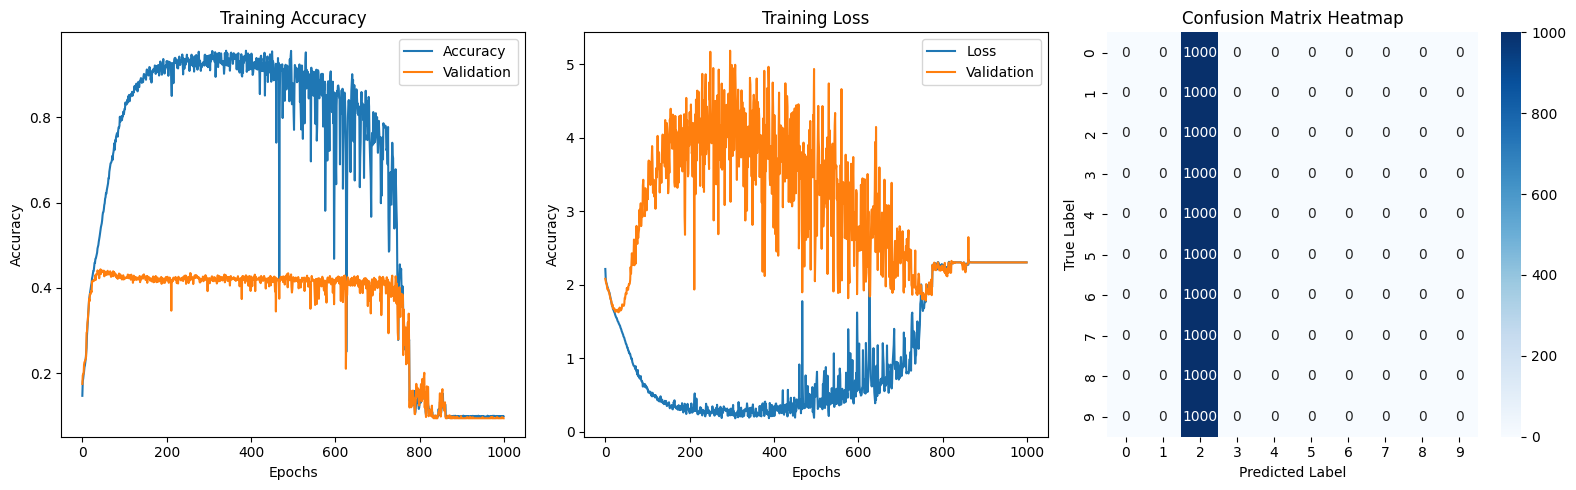

In [8]:
print("Dense Layer Model with Overfitting")
disp_performance(model_overfit, history)